# Creating player_centric features from games

In [1]:
# Simple Chess Player Types Analysis
# For "Game-based quantification of chess player types" Master Thesis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set the style for our plots
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --------------------------------------------------
# 1. LOAD DATA AND TRANSFORM TO PLAYER-CENTRIC FORMAT
# --------------------------------------------------

# Load the dataset
file_path = '../data/processed/lumbrasgigabase/only_book/chess_games_with_feats.csv'
chess_df = pd.read_csv(file_path)

# drop where result_category is Draw
# chess_df = chess_df[chess_df['result_category'] != 'Draw']
# chess_df.reset_index(drop=True, inplace=True)
# print(f"Loaded dataset with shape: {chess_df.shape}")


# change names of same players to the same name
name_changes = {
    "Kasparov, G.": "Kasparov, Garry",
    "Kasparov,G": "Kasparov, Garry",
    "Kasparov, G": "Kasparov, Garry",
    "Spassky, Boris Vasilievich": "Spassky, Boris V.",
    "Anand,V": "Anand, Viswanathan",
    "Larsen, B.": "Larsen, Bent",
    "Botvinnik, M.": "Botvinnik, Mikhail URS",
    "Moskalenko, Viktor1": "Moskalenko, Viktor",
    "Moskalenko, V.": "Moskalenko, Viktor",
    "Smyslov, V.": "Smyslov",
    "Petrosian, T.": "Petrosian",
    "Karpov, A.": "Karpov, Anatoly",
    "Bischoff,K": "Bischoff, K.",
    "Fischer, R.": "Fischer",
}

def replace_name(name):
    return name_changes.get(name, name)

chess_df['white'] = chess_df['white'].apply(replace_name)
chess_df['black'] = chess_df['black'].apply(replace_name)

print(f"Original dataset shape: {chess_df.shape}")

# Define known player types from the book
activist_players = [
    "Alekhine, Alexander", "Tal, Mikhail", "Spassky, Boris V.",
    "Kasparov, Garry", "Anand, Viswanathan", "Shirov, Alexei",
    "Morozevich, Alexander", "Topalov, Veselin", "Pillsbury, Harry",
    "Anderssen, Adolf", "Bronstein, David I", "Bronstein, Luis Marcos",
    "Larsen, Bent", "Taimanov, Mark E", "Aronian, Levon",
    "Polgar, Judit", "Muller, K."
]

theorist_players = [
    "Steinitz, Wilhelm", "Botvinnik, Mikhail URS", "Kramnik, Vladimir", "Tarrasch, Siegbert",
    "Nimzowitsch, Aron", "Leko, Peter", "Giri, Anish", "Meier, Georg",
    "Andersson, Ulf", "Sedlak, Nikola", "Tiviakov, Sergei", "Ponomariov, Ruslan",
    "Wahls, Matthias", "Moskalenko, Viktor", "Dorfman, Iossif", "Bangiev, Alexander", "Hansen, Lars Bo"
]

reflector_players = [
    "Capablanca, Jose", "Smyslov", "Petrosian", 
    "Karpov, Anatoly", "Carlsen, Magnus", "Adams, Michael", "Keymer, Vincent",
    "Bischoff, K."
]

pragmatist_players = [
    "Fischer", "Euwe, Max", "Korchnoi, Viktor", "Caruana, Fabiano",
    "Ding, Liren", "Karjakin, Sergey", "Vachier-Lagrave, Maxime"
]





# Create a dictionary mapping player names to their types
player_type_map = {}
for player in activist_players:
    player_type_map[player] = "Activist"
for player in theorist_players:
    player_type_map[player] = "Theorist"  
for player in reflector_players:
    player_type_map[player] = "Reflector"
for player in pragmatist_players:
    player_type_map[player] = "Pragmatist"

# Identify categorical, identifier, and numerical features
categorical_cols = ['event', 'site', 'date', 'round', 'white', 'black', 'result',
                   'white_title', 'black_title', 'eco', 'opening', 'result_category', 
                   'eco_family', 'opening_name']
identifier_cols = ['white_elo', 'black_elo', 'year']

# Get all columns, then remove categorical and identifier columns to get numerical features
all_cols = chess_df.columns.tolist()
numerical_features = [col for col in all_cols if col not in categorical_cols and col not in identifier_cols]

# Create a dataframe with just the numerical features for analysis
numerical_df = chess_df[numerical_features].copy()

# Split features into white-specific, black-specific, and common
white_features = [col for col in numerical_features if col.startswith('white_')]
black_features = [col for col in numerical_features if col.startswith('black_')]
common_features = [col for col in numerical_features if not col.startswith('white_') and not col.startswith('black_')]

print(f"\nFeature distribution:")
print(f"White player features: {len(white_features)}")
print(f"Black player features: {len(black_features)}")
print(f"Common game features: {len(common_features)}")

# --------------------------------------------------
# 2. CREATE PLAYER-CENTRIC DATAFRAME
# --------------------------------------------------

# Define phase-specific features where 0 means "phase not played"
phase_specific_features = [
    'white_opening_accuracy', 'white_middlegame_accuracy', 'white_endgame_accuracy',
    'black_opening_accuracy', 'black_middlegame_accuracy', 'black_endgame_accuracy'
]

# Create two new dataframes for players
players_data = []

# Process white players
for i, row in chess_df.iterrows():
    player_data = {}
    
    # Add player info
    player_data['player_name'] = row['white'] if 'white' in chess_df.columns else f"White_Player_{i}"
    player_data['player_color'] = 'white'
    player_data['opponent_name'] = row['black'] if 'black' in chess_df.columns else f"Black_Player_{i}"
    player_data['player_elo'] = row['white_elo'] if 'white_elo' in chess_df.columns else None
    player_data['date'] = row['date'] if 'date' in chess_df.columns else None
    player_data['eco'] = row['eco'] if 'eco' in chess_df.columns else None
    player_data['eco_family'] = row['eco_family'] if 'eco_family' in chess_df.columns else None
    player_data['opening_name'] = row['opening_name'] if 'opening_name' in chess_df.columns else None
    
    # Add player type if known
    if 'white' in chess_df.columns and row['white'] in player_type_map:
        player_data['player_type'] = player_type_map[row['white']]
    else:
        player_data['player_type'] = None
    
    # Add game identifiers
    player_data['game_id'] = i
    if 'result' in chess_df.columns:
        player_data['result'] = row['result']
    
    # Add player-specific features (removing the prefix)
    for feature in white_features:
        feature_name = feature.replace('white_', '')
        value = numerical_df.iloc[i][feature]
        

        player_data[feature_name] = value
    
    # Add common features
    for feature in common_features:
        player_data[feature] = numerical_df.iloc[i][feature]
    
    players_data.append(player_data)

# Process black players
for i, row in chess_df.iterrows():
    player_data = {}
    
    # Add player info
    player_data['player_name'] = row['black'] if 'black' in chess_df.columns else f"Black_Player_{i}"
    player_data['player_color'] = 'black'
    player_data['opponent_name'] = row['white'] if 'white' in chess_df.columns else f"White_Player_{i}"
    player_data['player_elo'] = row['black_elo'] if 'black_elo' in chess_df.columns else None
    player_data['date'] = row['date'] if 'date' in chess_df.columns else None
    player_data['eco'] = row['eco'] if 'eco' in chess_df.columns else None
    player_data['eco_family'] = row['eco_family'] if 'eco_family' in chess_df.columns else None
    player_data['opening_name'] = row['opening_name'] if 'opening_name' in chess_df.columns else None
    
    # Add player type if known
    if 'black' in chess_df.columns and row['black'] in player_type_map:
        player_data['player_type'] = player_type_map[row['black']]
    else:
        player_data['player_type'] = None
    
    # Add game identifiers
    player_data['game_id'] = i
    if 'result' in chess_df.columns:
        player_data['result'] = row['result']
    
    # Add player-specific features (removing the prefix)
    for feature in black_features:
        feature_name = feature.replace('black_', '')
        value = numerical_df.iloc[i][feature]
        

        player_data[feature_name] = value
    
    # Add common features
    for feature in common_features:
        player_data[feature] = numerical_df.iloc[i][feature]
    
    players_data.append(player_data)

# Convert to dataframe
players_df = pd.DataFrame(players_data)




print(f"\nPlayer-centric dataset shape: {players_df.shape}")
print(f"This represents {chess_df.shape[0]} games × 2 players = {chess_df.shape[0]*2} player instances")

# Count players with known types
known_types_count = players_df['player_type'].notna().sum()
print(f"\nPlayers with known types in dataset: {known_types_count} ({known_types_count/len(players_df)*100:.2f}%)")

# Count by type
if known_types_count > 0:
    type_counts = players_df['player_type'].value_counts()
    print("\nDistribution of known player types:")
    print(type_counts)


# Save the player-centric dataframe for future use
players_df.to_csv('player_centric_data.csv', index=False)
print("\nSaved player-centric data to 'player_centric_data.csv'")

Original dataset shape: (49711, 85)

Feature distribution:
White player features: 31
Black player features: 31
Common game features: 6

Player-centric dataset shape: (99422, 48)
This represents 49711 games × 2 players = 99422 player instances

Players with known types in dataset: 53999 (54.31%)

Distribution of known player types:
player_type
Theorist      17323
Activist      16388
Pragmatist    10319
Reflector      9969
Name: count, dtype: int64

Saved player-centric data to 'player_centric_data.csv'


# Feature analysis

In [2]:
# Chess Player Type Analysis - Feature Exploration
# Based on the thesis: "Game-based quantification of chess player types"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set the style for our visualizations
plt.style.use('fivethirtyeight')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Load the dataset
df = pd.read_csv('player_centric_data.csv')

# Display basic information about the dataset
print(f"Dataset Shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
display(missing_values[missing_values > 0])

# Basic statistics of numerical features
print("\nBasic Statistics:")
display(df.describe())

Dataset Shape: (99422, 48)

First few rows:


player_name player_color     opponent_name  player_elo  \
0  Kupreichik, Viktor D        white      Tal, Mikhail      2540.0   
1           Keres, Paul        white      Tal, Mikhail         NaN   
2          Tal, Mikhail        white  Keene, Raymond D         NaN   
3        Klovans, Janis        white      Tal, Mikhail         NaN   
4          Tal, Mikhail        white        Benko, Pal         NaN   

         date  eco eco_family  \
0  1979-12-01  B97          B   
1  1961-10-16  D30          D   
2  1964-01-10  B15          B   
3  1951-01-01  C52          C   
4  1959-01-01  B27          A   

                                        opening_name player_type  game_id  \
0  Sicilian Defense: Najdorf Variation, Poisoned ...         NaN        0   
1      Queen's Gambit Declined: Capablanca Variation         NaN        1   
2                 Caro-Kann Defense: Alekhine Gambit    Activist        2   
3     Italian Game: Evans Gambit, Sokolsky Variation         NaN        3   
4              Modern Defense: Pterodactyl Variation    Activist        4   

   ... blunder_count  top_move_alignment  top2_3_move_alignment  sharpness  \
0  ...      0.000000            0.700000               0.220000   2.501763   
1  ...      0.000000            0.315789               0.473684   1.501872   
2  ...      0.033333            0.533333               0.133333   2.021509   
3  ...      0.000000            0.475000               0.200000   8.298026   
4  ...      0.100000            0.433333               0.333333   2.700204   

   total_moves  opening_length  middlegame_length  endgame_length  \
0           50        0.240000           0.320000        0.440000   
1           19        0.736842           0.263158        0.000000   
2           30        0.400000           0.466667        0.133333   
3           40        0.175000           0.725000        0.100000   
4           30        0.266667           0.733333        0.000000   

   material_balance_std  opening_novelty_score  
0     1.319810592471511               0.583333  
1    1.8029123929484048               0.214286  
2      1.43158970128661               0.333333  
3     1.791187423277396               1.000000  
4    1.2310790208412925               0.375000  

[5 rows x 48 columns]


Missing Values:


player_elo      14956
eco                 4
opening_name        4
player_type     45423
dtype: int64


Basic Statistics:


player_elo       game_id  minor_piece_development  queen_development  \
count  84466.000000  99422.000000             99422.000000       99422.000000   
mean    2612.872647  24855.000000                 0.400641           0.383569   
std      172.047141  14350.401782                 0.216840           0.231676   
min      700.000000      0.000000                 0.000000           0.000000   
25%     2533.000000  12427.250000                 0.243902           0.214286   
50%     2650.000000  24855.000000                 0.339286           0.323529   
75%     2737.000000  37282.750000                 0.500000           0.487179   
max     2882.000000  49710.000000                 1.000000           1.000000   

       queen_lifetime   castle_move  material_changes  piece_mobility_avg  \
count    99422.000000  99422.000000      99422.000000        99422.000000   
mean         0.764755      0.241051          0.105787           96.484689   
std          0.256726      0.176280          0.028131           33.039210   
min          0.000000      0.000000          0.000000         -182.000000   
25%          0.555556      0.129630          0.088889           75.921946   
50%          0.906458      0.209302          0.105263           97.475000   
75%          0.976744      0.322581          0.123077          118.771280   
max          1.000000      1.000000          0.266667          206.309091   

       pawn_structure_changes  pawn_control  ...  mistake_count  \
count            99422.000000  99422.000000  ...   99422.000000   
mean                 0.190087      1.526498  ...       0.011865   
std                  0.044150      0.101090  ...       0.021239   
min                  0.000000      0.496584  ...       0.000000   
25%                  0.160000      1.464267  ...       0.000000   
50%                  0.186047      1.527396  ...       0.000000   
75%                  0.215686      1.590621  ...       0.021277   
max                  0.600000      1.916667  ...       0.500000   

       blunder_count  top_move_alignment  top2_3_move_alignment     sharpness  \
count   99422.000000        99422.000000           99422.000000  99422.000000   
mean        0.007275            0.545822               0.288469      2.742393   
std         0.019462            0.115513               0.084156      1.323840   
min         0.000000            0.000000               0.000000      0.000000   
25%         0.000000            0.470588               0.232558      1.938307   
50%         0.000000            0.547619               0.285714      2.403732   
75%         0.000000            0.625000               0.340426      3.162072   
max         0.666667            1.000000               0.875000     18.710319   

        total_moves  opening_length  middlegame_length  endgame_length  \
count  99422.000000    99422.000000       99422.000000    99422.000000   
mean      39.577558        0.334600           0.433383        0.231977   
std       14.173828        0.168190           0.179870        0.215141   
min        0.000000        0.000000           0.000000        0.000000   
25%       30.000000        0.220000           0.298246        0.000000   
50%       39.000000        0.292683           0.432432        0.205882   
75%       49.000000        0.400000           0.571429        0.412957   
max      172.000000        1.000000           0.894737        0.863354   

       opening_novelty_score  
count           99422.000000  
mean                0.404277  
std                 0.209229  
min                 0.000000  
25%                 0.250000  
50%                 0.368421  
75%                 0.538462  
max                 1.000000  

[8 rows x 38 columns]

In [3]:


# 1. Data Preprocessing

# Define known player types from the book (using the provided mappings)
activist_players = [
    "Alekhine, Alexander", "Tal, Mikhail", "Spassky, Boris V.",
    "Kasparov, Garry", "Anand, Viswanathan", "Shirov, Alexei",
    "Morozevich, Alexander", "Topalov, Veselin", "Pillsbury, Harry",
    "Anderssen, Adolf", "Bronstein, David I", "Bronstein, Luis Marcos",
    "Larsen, Bent", "Taimanov, Mark E", "Aronian, Levon",
    "Polgar, Judit", "Muller, K."
]

theorist_players = [
    "Steinitz, Wilhelm", "Botvinnik, Mikhail URS", "Kramnik, Vladimir", "Tarrasch, Siegbert",
    "Nimzowitsch, Aron", "Leko, Peter", "Giri, Anish", "Meier, Georg",
    "Andersson, Ulf", "Sedlak, Nikola", "Tiviakov, Sergei", "Ponomariov, Ruslan",
    "Wahls, Matthias", "Moskalenko, Viktor", "Dorfman, Iossif", "Bangiev, Alexander", "Hansen, Lars Bo"
]

reflector_players = [
    "Capablanca, Jose", "Smyslov", "Petrosian", 
    "Karpov, Anatoly", "Carlsen, Magnus", "Adams, Michael", "Keymer, Vincent",
    "Bischoff, K."
]

pragmatist_players = [
    "Fischer", "Euwe, Max", "Korchnoi, Viktor", "Caruana, Fabiano",
    "Ding, Liren", "Karjakin, Sergey", "Vachier-Lagrave, Maxime"
]

# Function to map players to their types
def assign_player_types():
    """Assign player types based on the known player classifications"""
    # Create a dictionary mapping player names to their types
    player_type_map = {}
    for player in activist_players:
        player_type_map[player] = "Activist"
    for player in theorist_players:
        player_type_map[player] = "Theorist"
    for player in reflector_players:
        player_type_map[player] = "Reflector"
    for player in pragmatist_players:
        player_type_map[player] = "Pragmatist"
    
    # Apply the mapping to the dataframe
    labeled_count = 0
    
    # Create a list to store player counts for sorting
    player_counts = []
    for player, player_type in player_type_map.items():
        mask = df['player_name'].str.contains(player, case=True, na=False)
        count = mask.sum()
        if count > 0:
            player_counts.append((player, player_type, mask, count))
    
    # Sort by count in descending order
    player_counts.sort(key=lambda x: x[3], reverse=True)
    
    # Apply the player types in order of count
    for player, player_type, mask, count in player_counts:
        df.loc[mask, 'player_type'] = player_type
        labeled_count += count
        print(f"Labeled {count} games for {player} as {player_type}")
    
    print(f"\nTotal labeled games: {labeled_count}")
    print(f"Player type distribution:")
    display(df['player_type'].value_counts())
    
    # Create color-based player type for visualizations
    color_map = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Reflector': 'green',
        'Pragmatist': 'purple'
    }
    
    df['player_type_color'] = df['player_type'].map(color_map)
    
    return labeled_count

# Apply the function to assign player types
labeled_count = assign_player_types()

# 2. Feature Grouping and Selection

# Group features by category for easier analysis
feature_groups = {
    'Opening Features': ['minor_piece_development', 'queen_development', 'castle_move', 'opening_novelty_score', 'opening_accuracy', 'opening_length'],
    'Queen Play': ['queen_lifetime'],
    'Material Handling': ['material_changes', 'material_balance_std'],
    'Positional Features': ['piece_mobility_avg', 'pawn_structure_changes', 'pawn_control', 'center_control_avg', 'space_advantage'],
    'King Safety': ['king_safety', 'vulnerability_spikes', 'check_frequency'],
    'Move Quality': ['accuracy', 'brilliant_count', 'great_count', 'good_moves', 'inaccuracy_count', 'mistake_count', 'blunder_count', 'top_move_alignment', 'top2_3_move_alignment'],
    'Game Phase': ['middlegame_accuracy', 'endgame_accuracy', 'middlegame_length', 'endgame_length'],
    'Strategic Indicators': ['sacrifice_count', 'prophylactic_frequency', 'sharpness', 'avg_eval_change'],
    'Performance Metrics': ['critical_performance', 'weighted_alignment'],
    'Game Summary': ['total_moves']
}

# Function to get all numeric features
def get_numeric_features():
    """Return all numeric feature columns"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclude non-feature columns
    exclude_cols = ['player_elo', 'game_id', 'result']
    return [col for col in numeric_cols if col not in exclude_cols]

# Function to get a clean dataset with imputed values for analysis
def get_clean_data(df_input=None, features=None):
    """Return a clean dataset with imputed missing values"""
    if df_input is None:
        df_input = df
    
    if features is None:
        features = get_numeric_features()
    
    # Create a copy to avoid modifying the original
    data = df_input[features].copy()
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    data_imputed = imputer.fit_transform(data)
    
    # Convert back to DataFrame
    data_clean = pd.DataFrame(data_imputed, columns=features, index=df_input.index)
    
    return data_clean

Labeled 2856 games for Carlsen, Magnus as Reflector
Labeled 2767 games for Shirov, Alexei as Activist
Labeled 2460 games for Tiviakov, Sergei as Theorist
Labeled 2430 games for Aronian, Levon as Activist
Labeled 2415 games for Vachier-Lagrave, Maxime as Pragmatist
Labeled 2285 games for Sedlak, Nikola as Theorist
Labeled 2201 games for Caruana, Fabiano as Pragmatist
Labeled 2163 games for Giri, Anish as Theorist
Labeled 2108 games for Adams, Michael as Reflector
Labeled 1898 games for Anand, Viswanathan as Activist
Labeled 1848 games for Karjakin, Sergey as Pragmatist
Labeled 1829 games for Kramnik, Vladimir as Theorist
Labeled 1661 games for Korchnoi, Viktor as Pragmatist
Labeled 1623 games for Ponomariov, Ruslan as Theorist
Labeled 1451 games for Ding, Liren as Pragmatist
Labeled 1435 games for Karpov, Anatoly as Reflector
Labeled 1429 games for Topalov, Veselin as Activist
Labeled 1386 games for Meier, Georg as Theorist
Labeled 1365 games for Leko, Peter as Theorist
Labeled 1344 gam

player_type
Theorist      17323
Activist      16388
Pragmatist    10329
Reflector     10185
Name: count, dtype: int64

Starting exploratory data analysis...


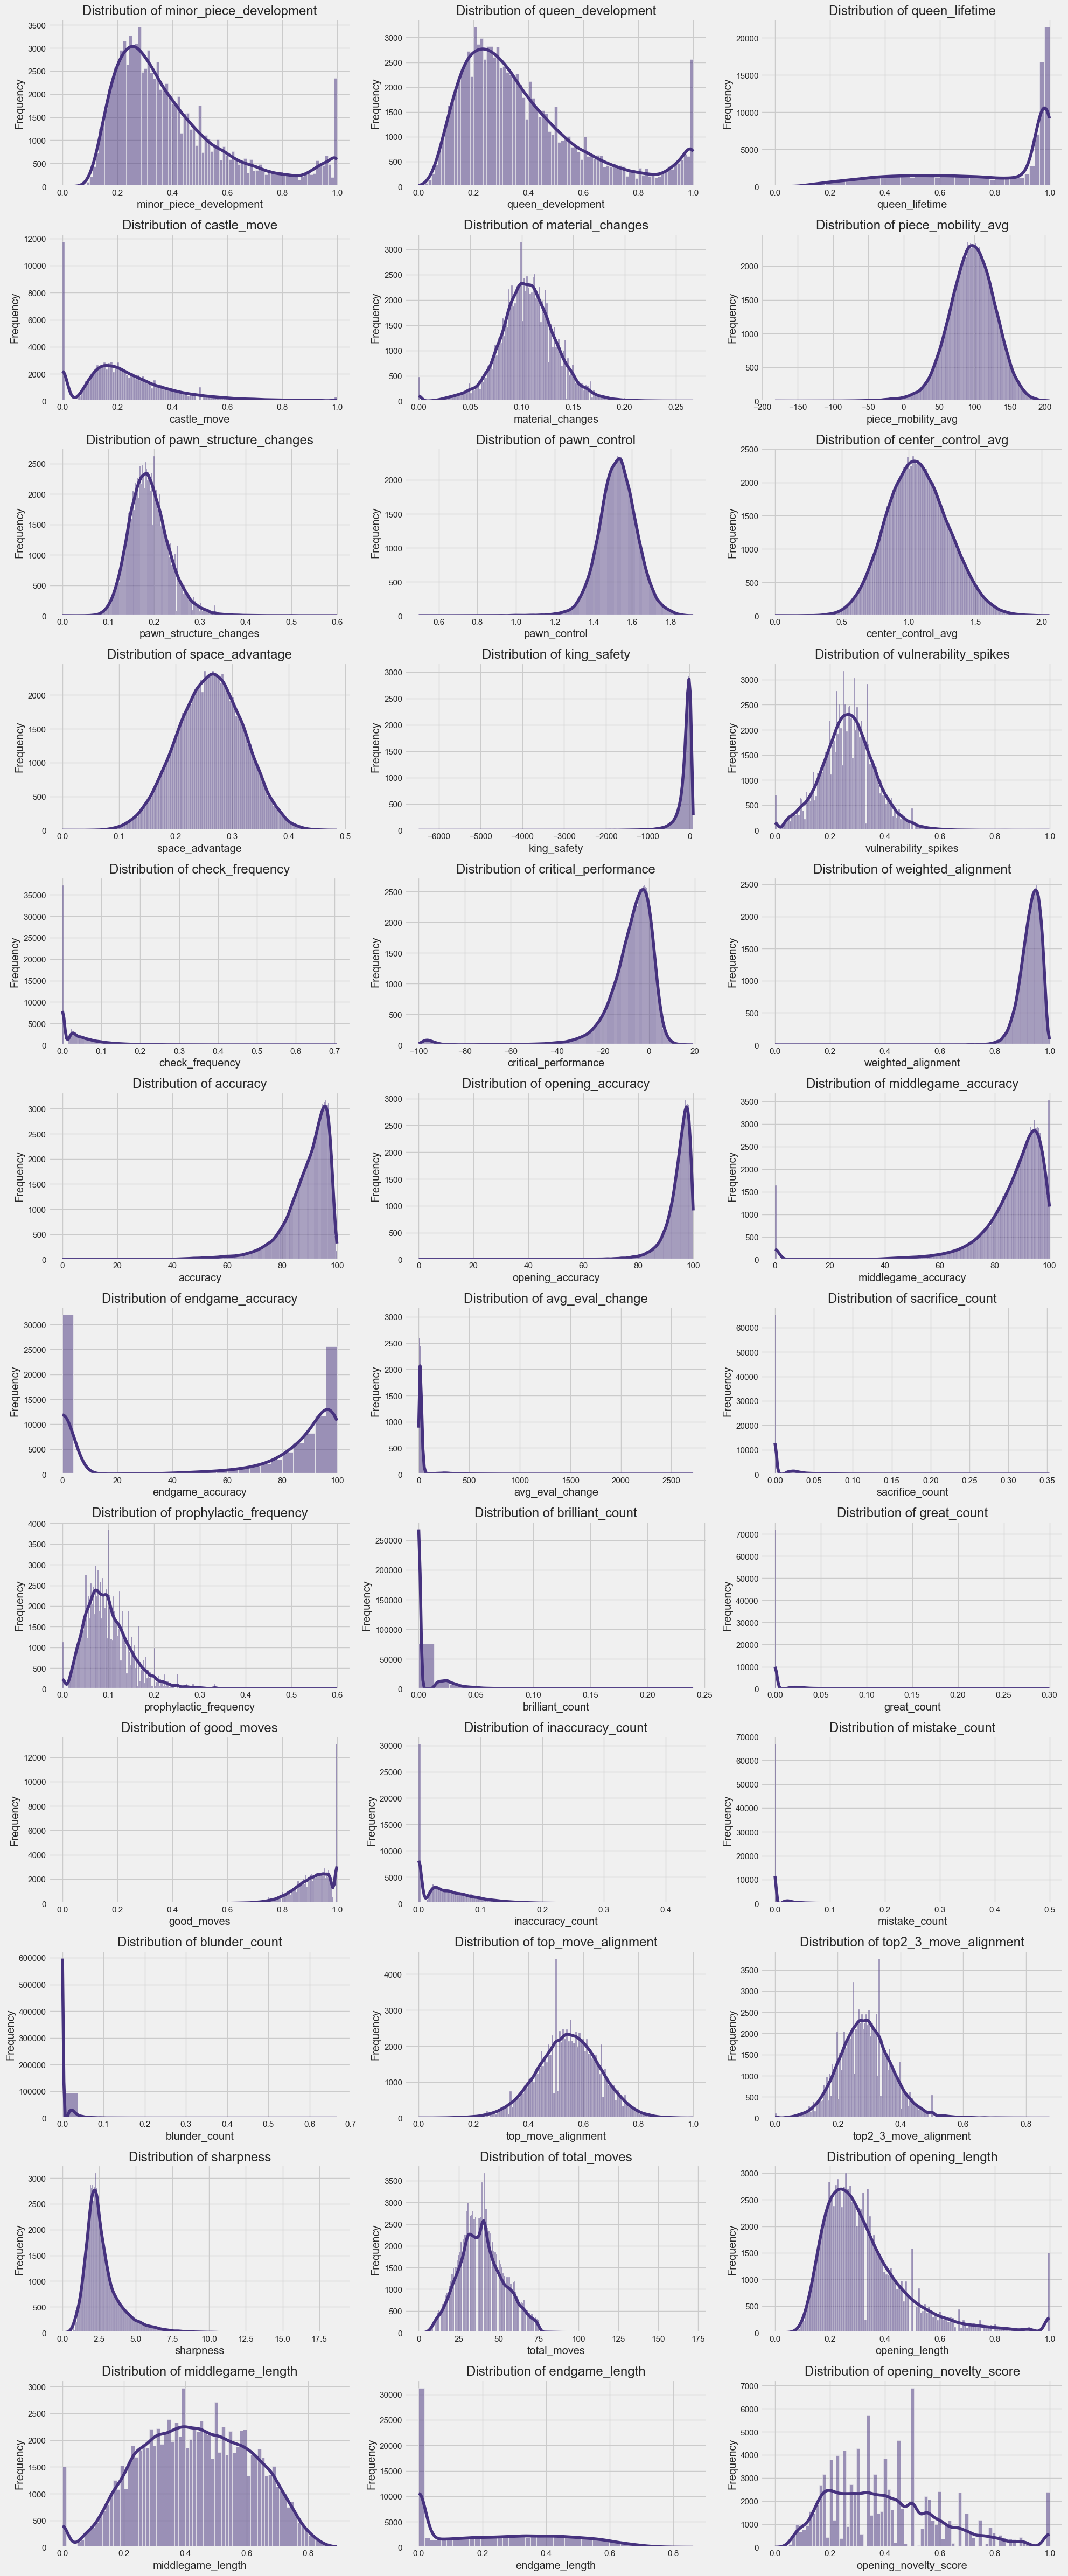

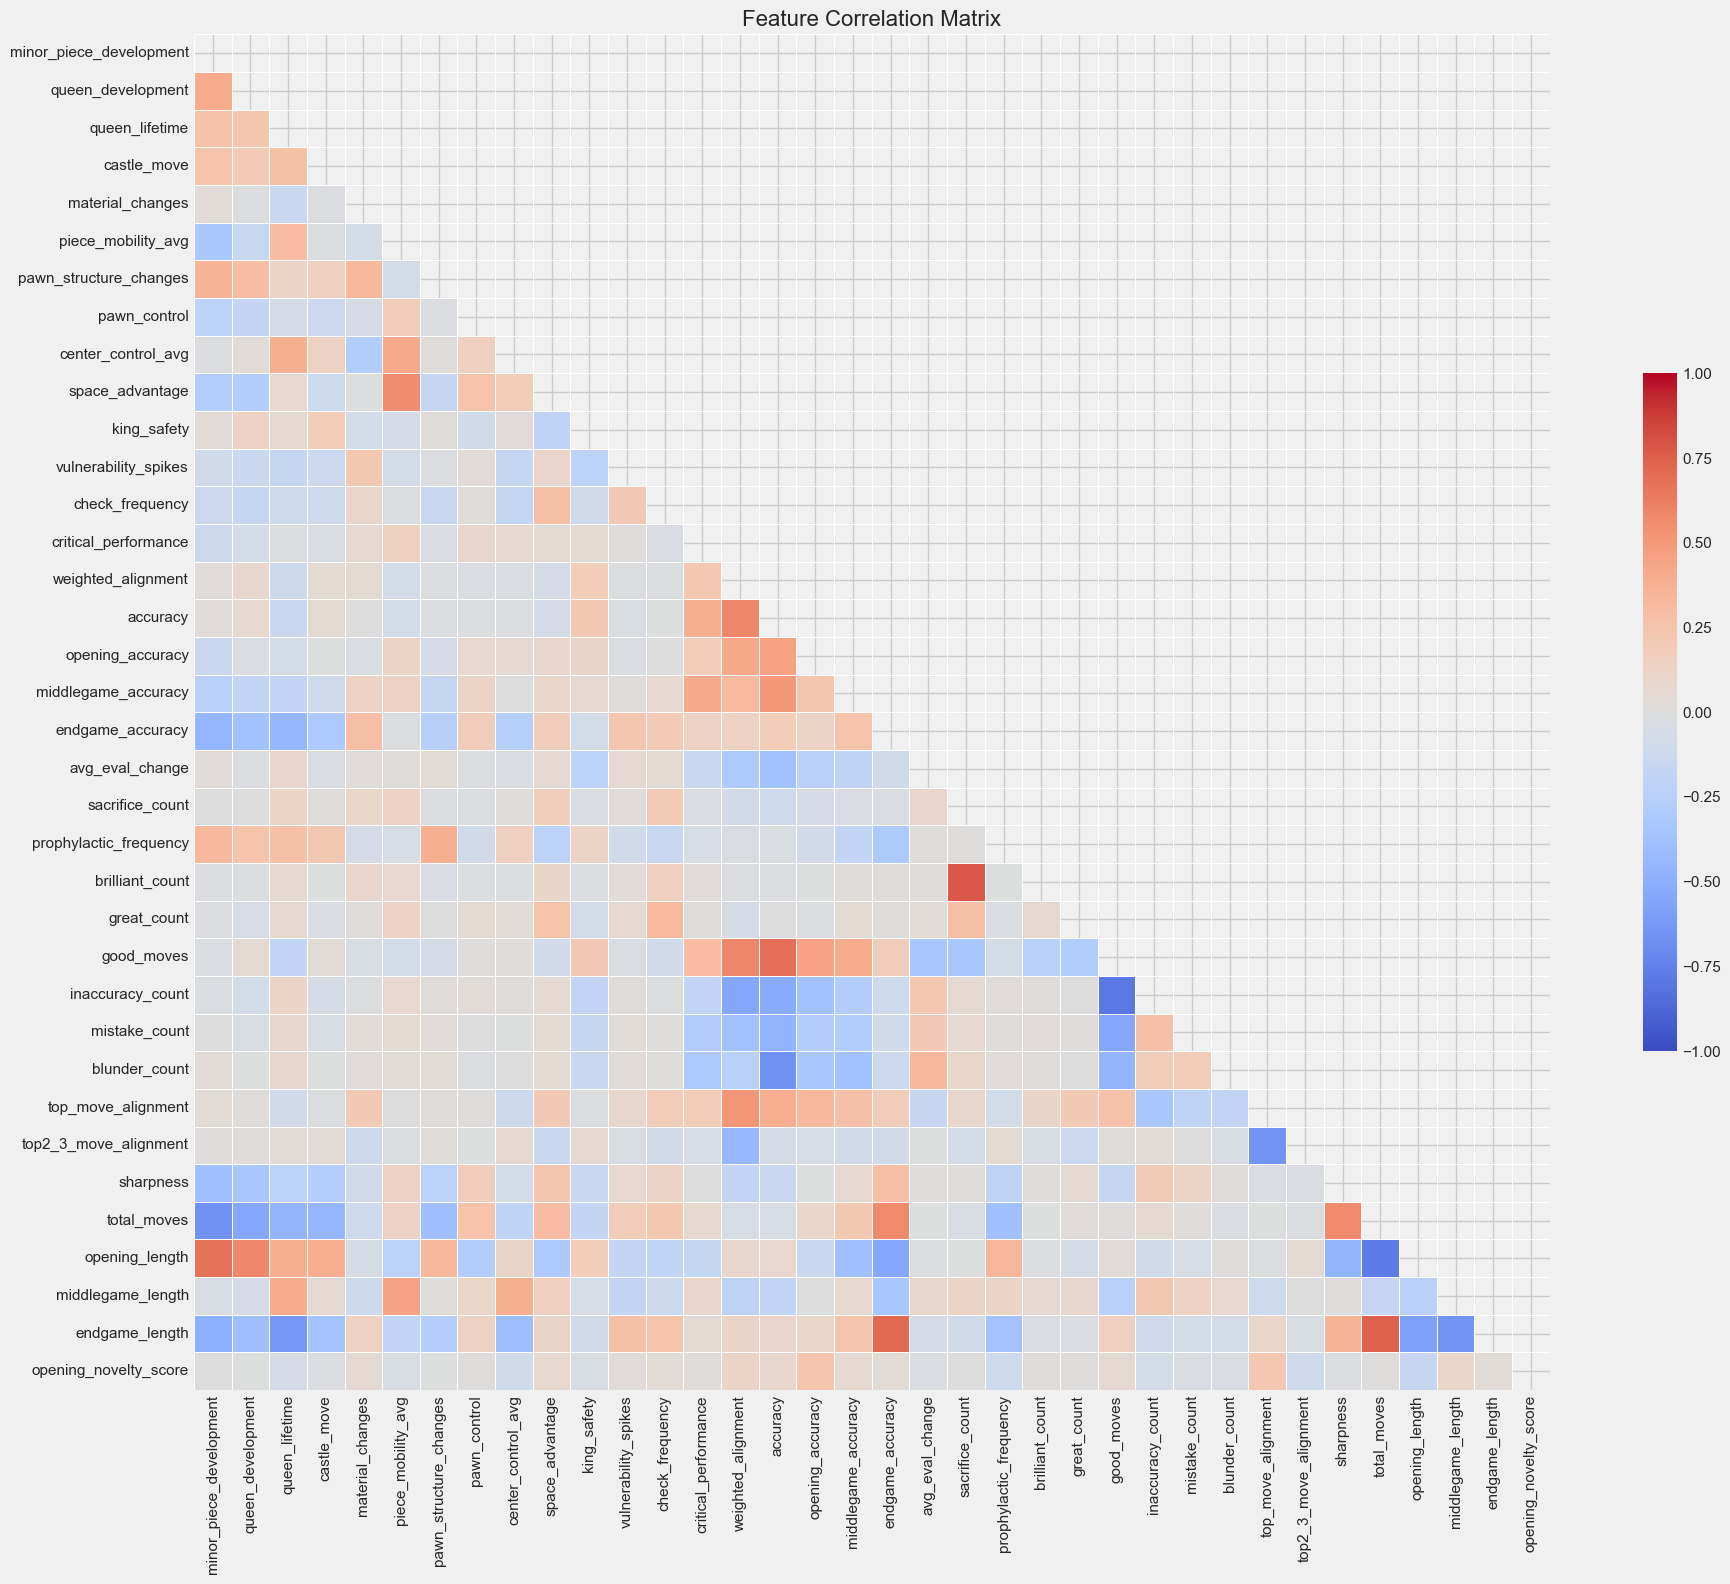


Highly correlated feature pairs (|r| > 0.7):
inaccuracy_count -- good_moves: -0.7938
brilliant_count -- sacrifice_count: 0.7775
opening_length -- total_moves: -0.7757
endgame_length -- total_moves: 0.7423
endgame_length -- endgame_accuracy: 0.7172

Performing Principal Component Analysis...


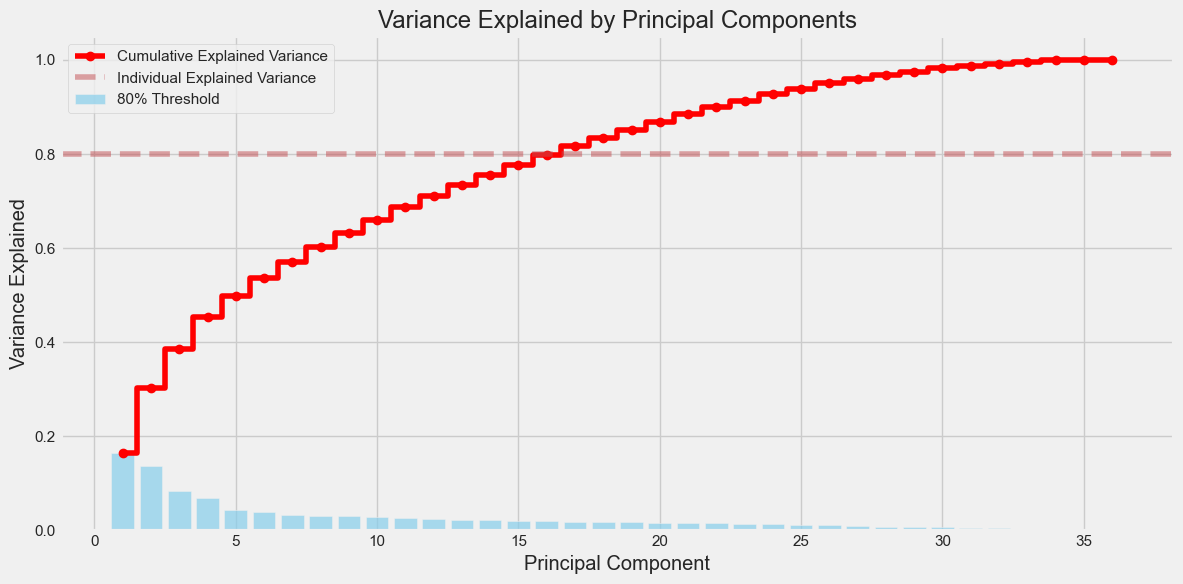


Number of components needed to explain 80% variance: 17


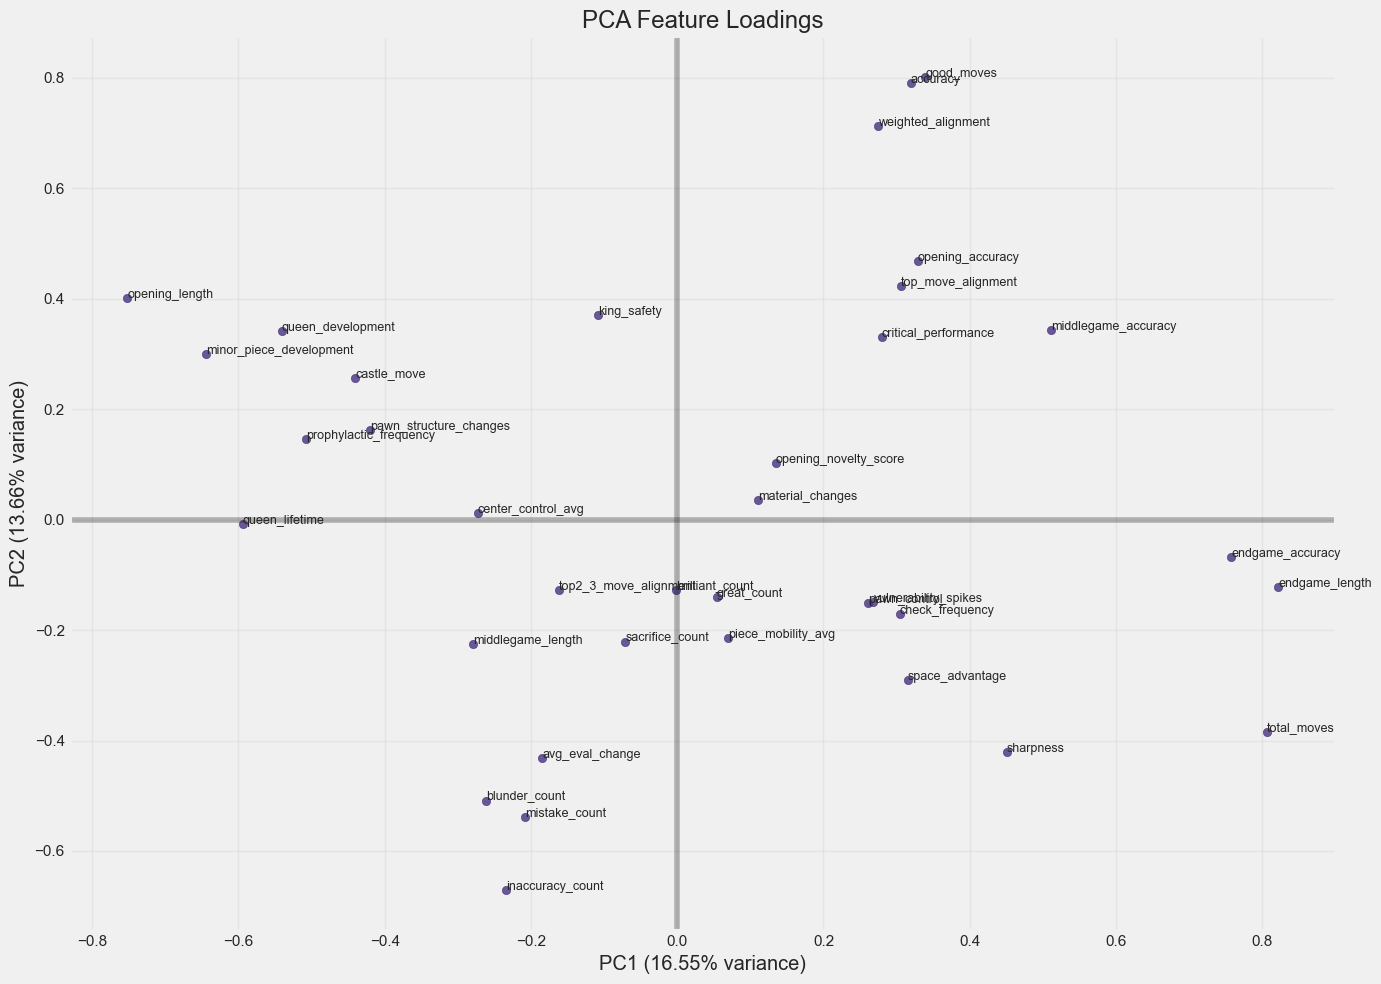

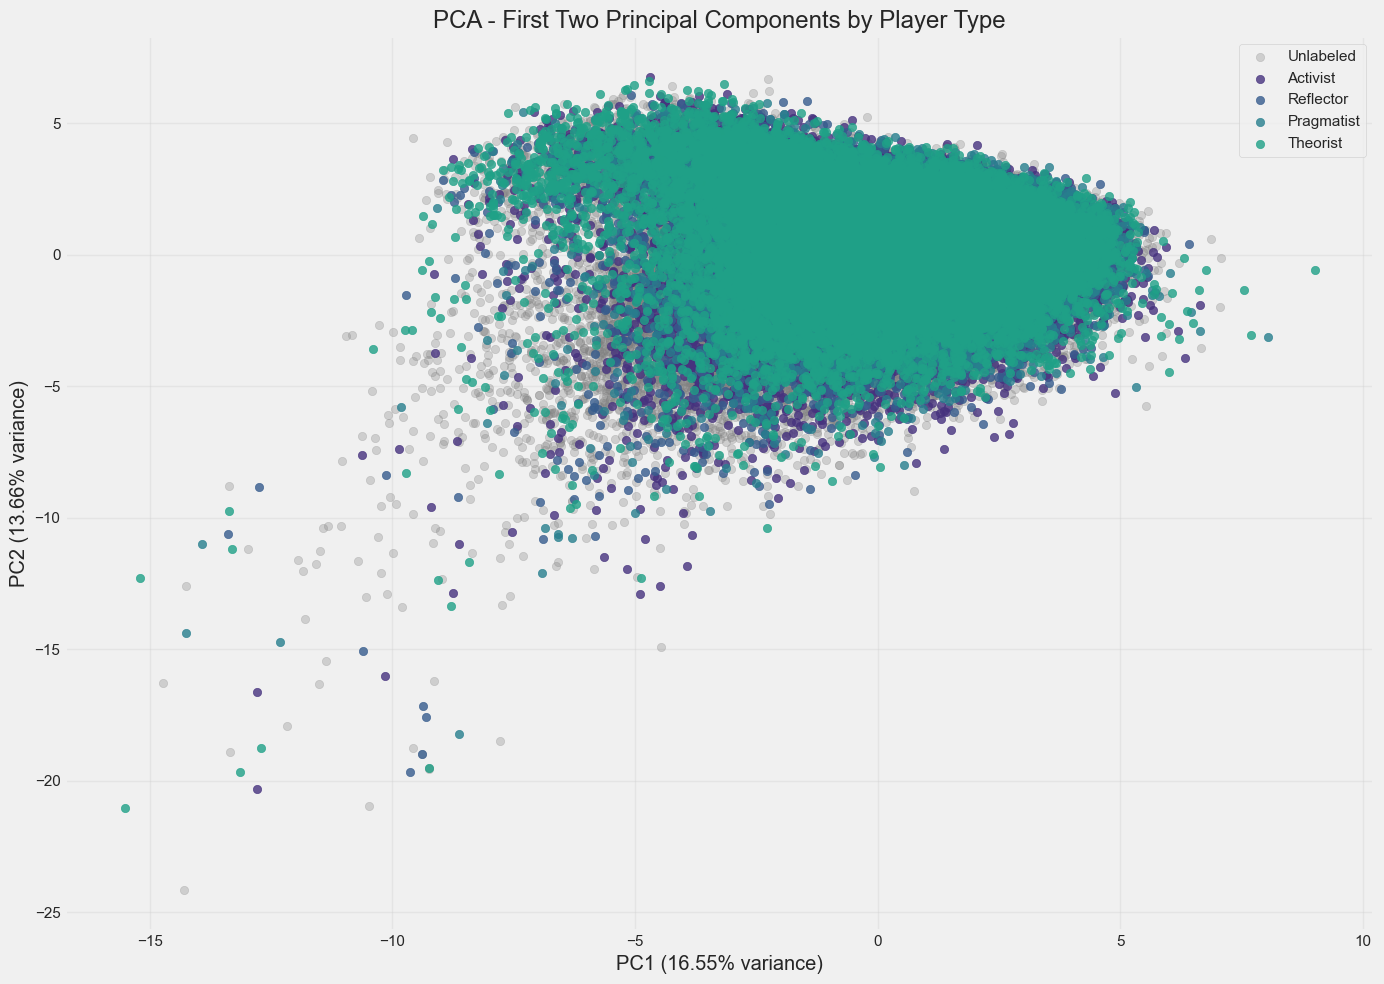


Performing t-SNE visualization...
Starting t-SNE visualization process...
Found 36 numeric features
Sampling 1000 out of 99422 data points
Working with 1000 samples
Found 538 labeled samples
Standardizing features...
Skipping PCA (fewer features than requested components)
Running t-SNE with perplexity=30, max_iter=1000...
t-SNE completed in 3.27 seconds


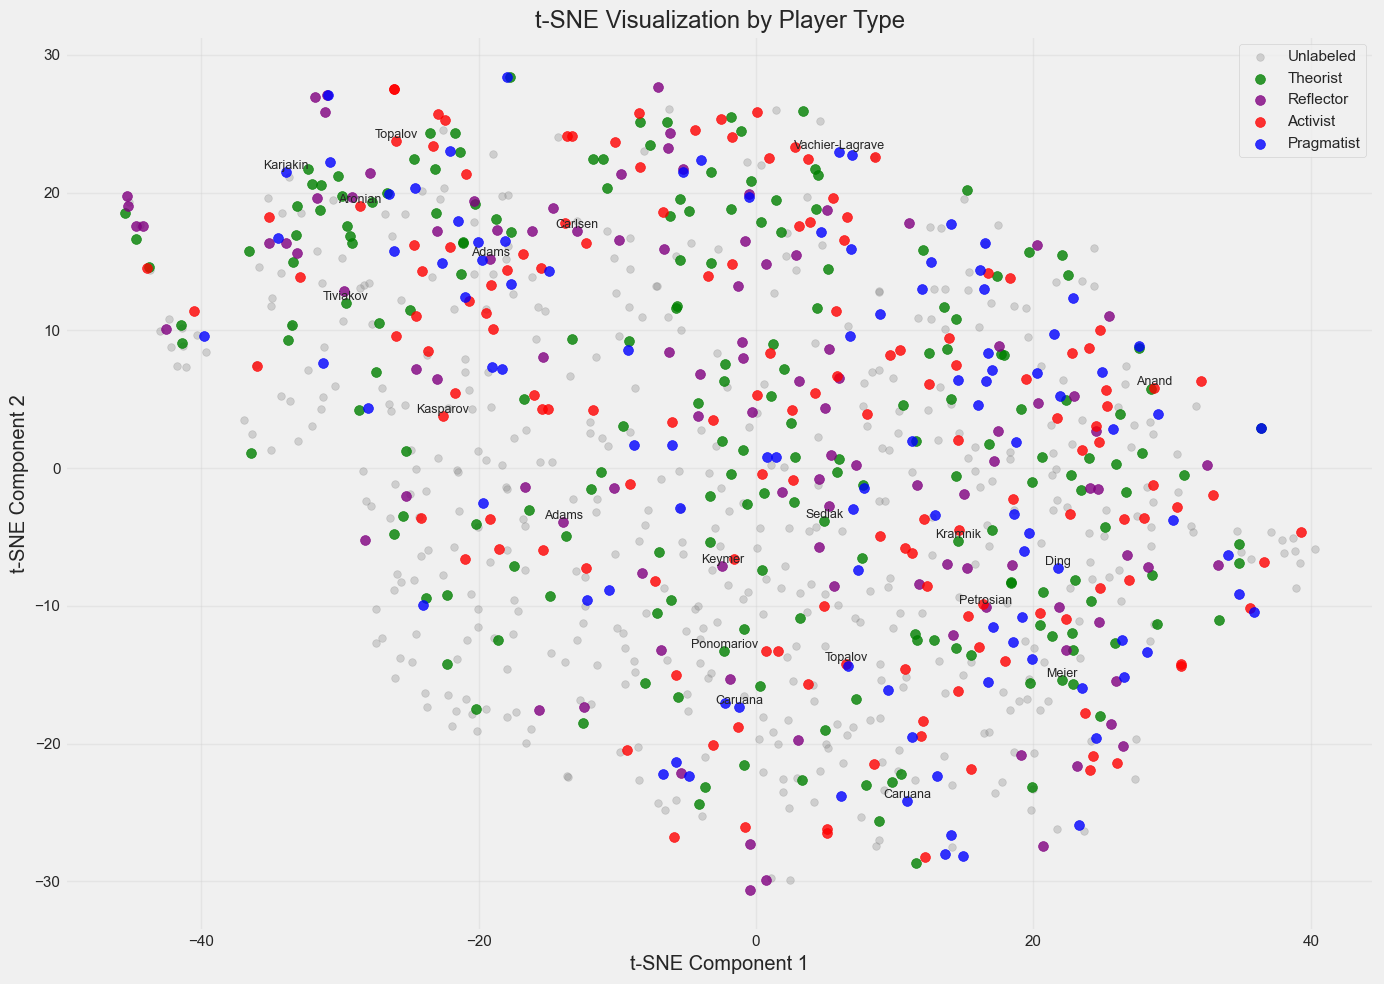


Analyzing features by player type...
Starting feature distribution analysis...
Found 53999 labeled data points

Player type distribution:
  Theorist: 17323 samples
  Activist: 16388 samples
  Pragmatist: 10319 samples
  Reflector: 9969 samples
Using 4 player types with 20+ samples each: ['Theorist', 'Activist', 'Pragmatist', 'Reflector']

Calculating feature significance...
Found 36 features with sufficient data
Processing feature 1/36...
Processing feature 11/36...
Processing feature 21/36...
Processing feature 31/36...

ANOVA calculations completed in 0.6 seconds

Most significant features differentiating player types:
1. space_advantage: p-value = 0.0000 ***
2. opening_novelty_score: p-value = 0.0000 ***
3. top_move_alignment: p-value = 0.0000 ***
4. opening_length: p-value = 0.0000 ***
5. good_moves: p-value = 0.0000 ***
6. material_changes: p-value = 0.0000 ***
7. total_moves: p-value = 0.0000 ***
8. opening_accuracy: p-value = 0.0000 ***
9. top2_3_move_alignment: p-value = 0.000

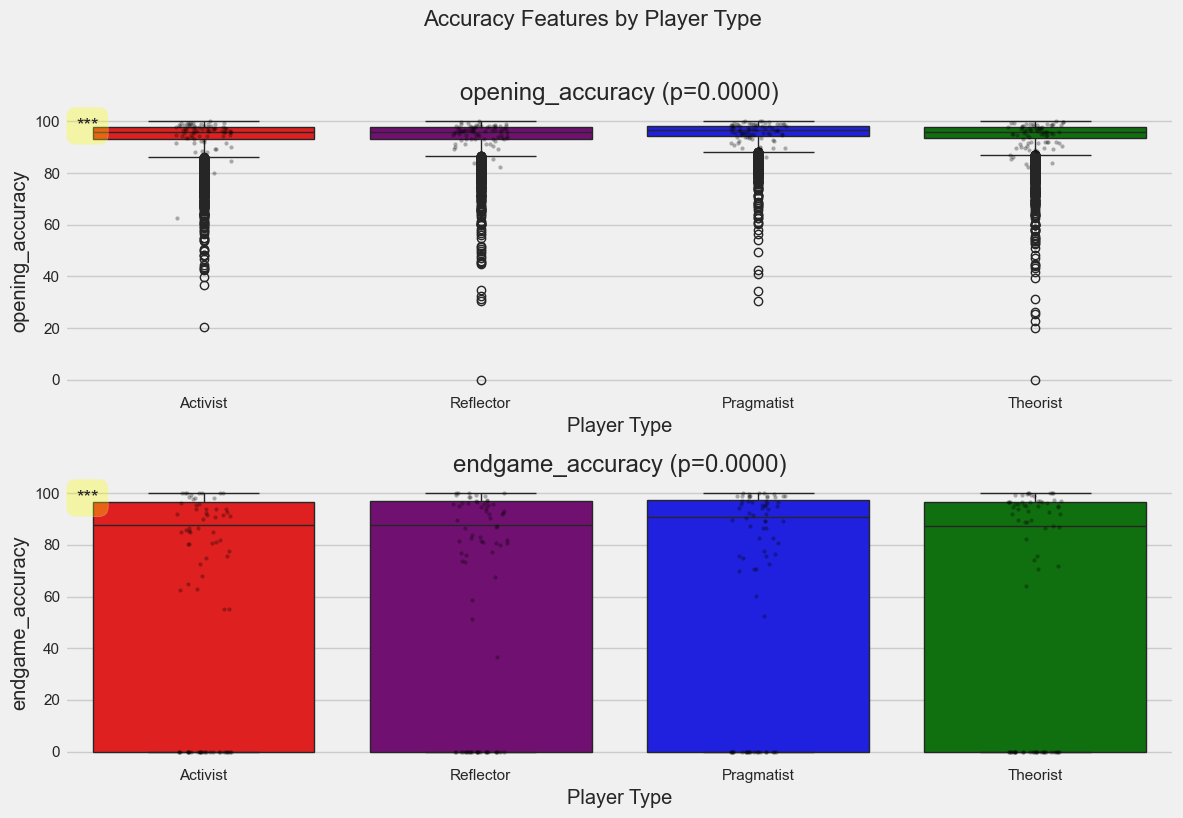

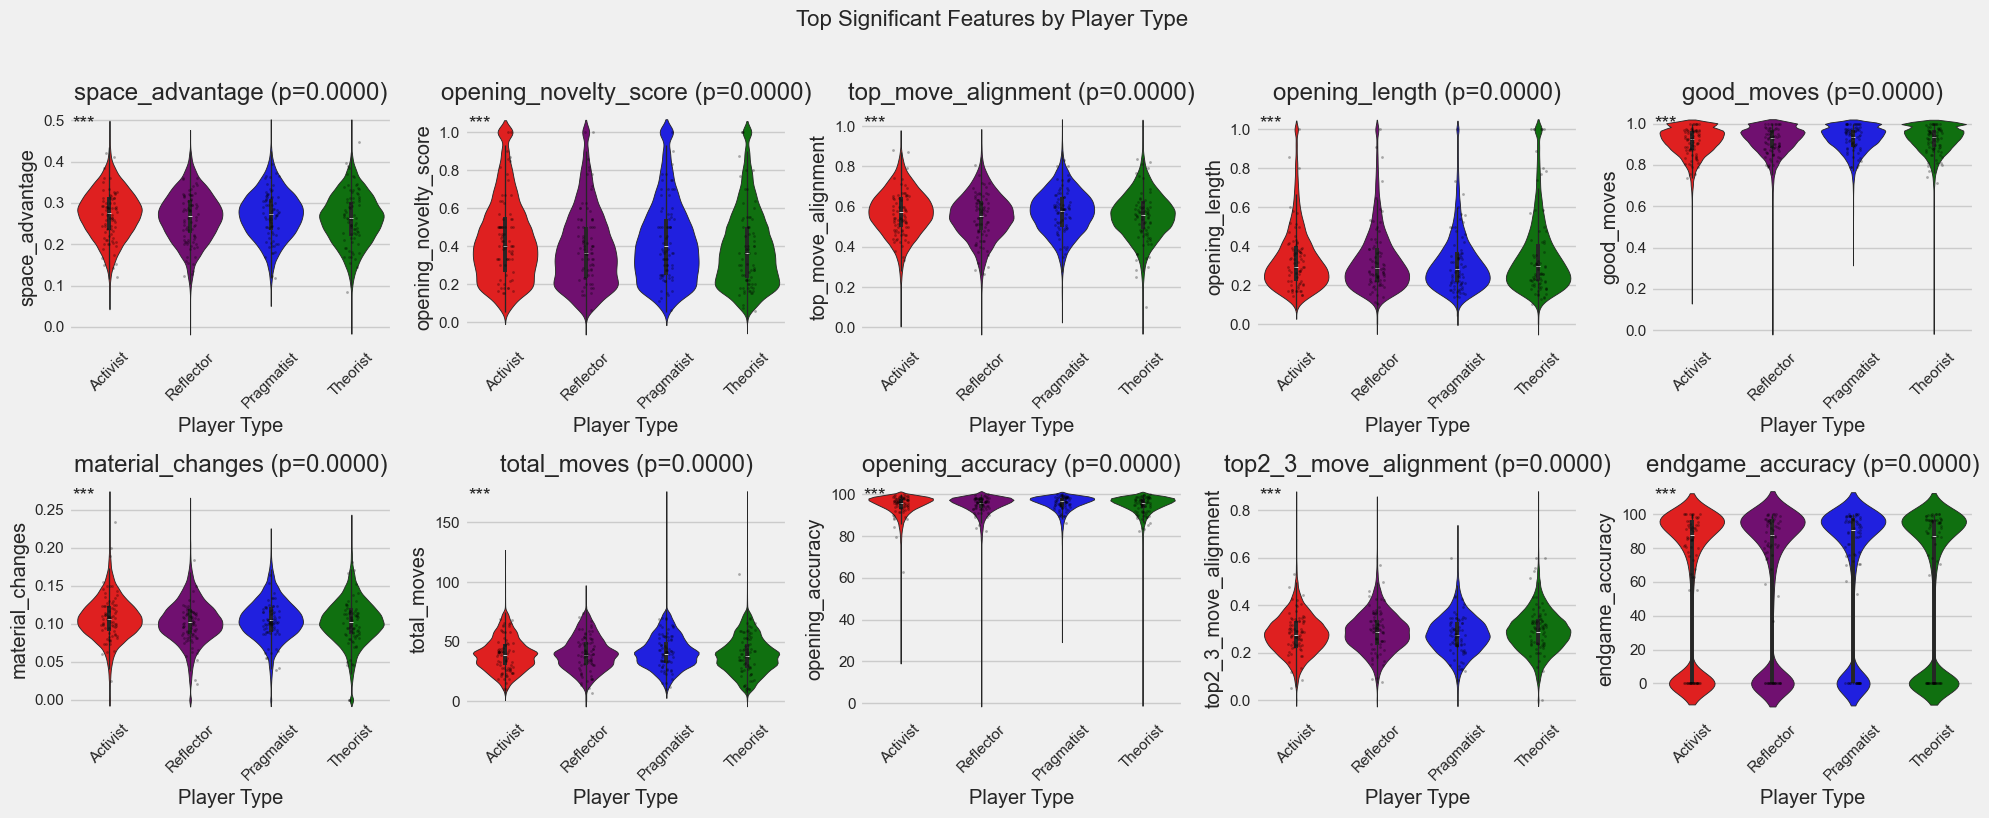


Feature distribution analysis completed in 3.3 seconds
Starting comprehensive player type analysis...

Player type distribution:
  Theorist: 17323 samples
  Activist: 16388 samples
  Pragmatist: 10319 samples
  Reflector: 9969 samples
Analyzing 36 numeric features across 4 player types
Calculating statistics for all features...

COMPREHENSIVE PLAYER TYPE FEATURE COMPARISON

Development & Initiative:
----------------------------------------------------------------------------------------------------
Feature                        p-value    Theorist   Activist   Pragmatist Reflector  Effect    
----------------------------------------------------------------------------------------------------
minor_piece_development ***    0.0000     0.407      0.407      0.383      0.378      7.6%      
castle_move ***                0.0000     0.250      0.241      0.228      0.237      9.7%      
check_frequency ***            0.0000     0.044      0.049      0.048      0.046      12.9%     
queen_

In [5]:
# 3. Exploratory Data Analysis

# 3.1 Distribution Analysis for all numeric features
def plot_feature_distributions():
    """Plot histograms for all numeric features"""
    numeric_features = get_numeric_features()
    
    # Calculate number of rows and columns for subplots
    n_features = len(numeric_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
    axes = axes.flatten()
    
    for i, feature in enumerate(numeric_features):
        if i < len(axes):
            sns.histplot(df[feature].dropna(), kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')
            
            # Add missing value count if any
            na_count = df[feature].isna().sum()
            if na_count > 0:
                axes[i].annotate(f'Missing: {na_count}', xy=(0.7, 0.9), xycoords='axes fraction',
                              fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        if j < len(axes):
            axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_features_by_player_type(df, feature_groups=None, max_features_per_group=3, 
                                max_groups=2, min_samples=10, alpha=0.01,
                                use_swarmplot=False, sample_size=400, dpi=100,
                                skip_plots=False):
    """
    Plot feature distributions grouped by player type - high performance version
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data
    feature_groups : dict, optional
        Dictionary of feature groups to plot. If None, will use predefined groups.
    max_features_per_group : int, default=3
        Maximum features to plot per group
    max_groups : int, default=2
        Maximum number of feature groups to plot
    min_samples : int, default=10
        Minimum samples required per player type to include feature
    alpha : float, default=0.01
        Significance threshold for ANOVA tests
    use_swarmplot : bool, default=False
        Whether to use swarmplot (slow) or stripplot (fast)
    sample_size : int, default=400
        Maximum number of points to plot per chart (for speed)
    dpi : int, default=100
        Resolution for saved images
    skip_plots : bool, default=False
        If True, only calculates significant features without plotting
    
    Returns:
    --------
    dict : Dictionary of feature p-values
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    from scipy import stats
    import time
    
    start_time = time.time()
    print("Starting feature distribution analysis...")
    
    # Count labeled data points
    labeled_count = df['player_type'].notna().sum()
    
    if labeled_count == 0:
        print("No labeled data found. Cannot create player type distributions.")
        return {}
        
    print(f"Found {labeled_count} labeled data points")
    
    # Create a dataframe of only labeled data
    labeled_df = df[df['player_type'].notna()].copy()
    
    # Get player type counts
    type_counts = labeled_df['player_type'].value_counts()
    print("\nPlayer type distribution:")
    for pt, count in type_counts.items():
        print(f"  {pt}: {count} samples")
    
    # Skip types with too few samples
    valid_types = type_counts[type_counts >= min_samples].index.tolist()
    if len(valid_types) < 2:
        print(f"Need at least 2 player types with {min_samples}+ samples each. Analysis stopped.")
        return {}
    
    print(f"Using {len(valid_types)} player types with {min_samples}+ samples each: {valid_types}")
    
    # Filter to keep only valid player types
    labeled_df = labeled_df[labeled_df['player_type'].isin(valid_types)]
    
    # Get numeric features
    metadata_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                   'player_type', 'game_id', 'result']
    numeric_features = [col for col in df.columns 
                      if col not in metadata_cols and pd.api.types.is_numeric_dtype(df[col])]
    
    # Define feature groups if not provided
    if feature_groups is None:
        feature_groups = {
            'Accuracy Features': [f for f in numeric_features if 'accuracy' in f],
            'Tactical Features': [f for f in numeric_features if any(x in f for x in 
                                 ['sacrifice', 'brilliant', 'blunder', 'mistake', 'sharpness'])],
            'Positional Features': [f for f in numeric_features if any(x in f for x in 
                                  ['prophylactic', 'mobility', 'center_control', 'king_safety'])],
            'Strategic Features': [f for f in numeric_features if any(x in f for x in
                                 ['space_advantage', 'pawn_control', 'material_balance'])]
        }
    
    # Limit to max_groups
    feature_groups = dict(list(feature_groups.items())[:max_groups])
    
    # Find significant features
    print("\nCalculating feature significance...")
    start_calc_time = time.time()
    all_p_values = {}
    
    # Calculate data availability for each feature
    feature_availability = {}
    for feature in numeric_features:
        # Count non-missing values per player type
        availability = labeled_df.groupby('player_type')[feature].count()
        # Only include feature if all player types have sufficient samples
        if (availability >= min_samples).all():
            feature_availability[feature] = availability.min()
    
    print(f"Found {len(feature_availability)} features with sufficient data")
    
    # Calculate ANOVA p-values for features with sufficient data
    total_features = len(feature_availability)
    for i, (feature, min_avail) in enumerate(feature_availability.items()):
        # Progress reporting for long calculations
        if i % 10 == 0:
            print(f"Processing feature {i+1}/{total_features}...")
            
        # Create clean data for this feature
        feature_data = labeled_df[['player_type', feature]].dropna()
        
        # Create groups for ANOVA
        groups = [feature_data[feature_data['player_type'] == pt][feature].values 
                 for pt in feature_data['player_type'].unique()]
        
        try:
            f_val, p_val = stats.f_oneway(*groups)
            all_p_values[feature] = p_val
        except:
            # Skip if ANOVA fails
            continue
    
    # Sort features by p-value
    sorted_features = sorted(all_p_values.items(), key=lambda x: x[1])
    
    # Print most significant features
    print(f"\nANOVA calculations completed in {time.time() - start_calc_time:.1f} seconds")
    print("\nMost significant features differentiating player types:")
    for i, (feature, p_val) in enumerate(sorted_features[:10]):
        significant = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        print(f"{i+1}. {feature}: p-value = {p_val:.4f} {significant}")
    
    # Skip plotting if requested
    if skip_plots:
        print("Skipping plots as requested.")
        print(f"Analysis completed in {time.time() - start_time:.1f} seconds")
        return dict(sorted_features)
    
    # Plot feature distributions for each group
    print("\nCreating distribution plots...")
    for group_name, features in feature_groups.items():
        # Filter to features that exist in the dataset and have p-values
        valid_features = [f for f in features if f in all_p_values]
        
        if not valid_features:
            print(f"No valid features in group: {group_name}")
            continue
            
        # Sort by significance and take top N
        sorted_features_group = sorted([(f, all_p_values[f]) for f in valid_features], 
                                key=lambda x: x[1])
        top_features = [f[0] for f in sorted_features_group[:max_features_per_group]]
        
        print(f"\nPlotting {len(top_features)} features from group: {group_name}")
        
        # Create the plot
        fig, axes = plt.subplots(len(top_features), 1, figsize=(12, 4*len(top_features)))
        if len(top_features) == 1:
            axes = [axes]
        
        plt.suptitle(f"{group_name} by Player Type", fontsize=16, y=1.02)
        
        # Define colors for player types
        type_colors = {
            'Activist': 'red',
            'Pragmatist': 'blue',
            'Theorist': 'green',
            'Reflector': 'purple'
        }
        
        # Create a custom palette based on player types
        palette = {pt: type_colors.get(pt, 'orange') for pt in valid_types}
        
        for i, feature in enumerate(top_features):
            # Get clean data (drop NaN for this visualization)
            feature_data = labeled_df[['player_type', feature]].dropna()
            
            # Box plot with custom palette
            sns.boxplot(x='player_type', y=feature, data=feature_data, 
                      palette=palette, ax=axes[i])
            
            # PERFORMANCE OPTIMIZATION: Sample data for individual points
            if use_swarmplot:
                # Use swarmplot (slow but accurate positioning)
                if len(feature_data) > sample_size:
                    # If we have a lot of data, sample it down
                    plot_sample = feature_data.groupby('player_type').apply(
                        lambda x: x.sample(min(len(x), sample_size//len(feature_data['player_type'].unique())), 
                                          random_state=42)
                    ).reset_index(drop=True)
                else:
                    plot_sample = feature_data
                
                sns.swarmplot(x='player_type', y=feature, data=plot_sample, 
                            color='black', alpha=0.3, size=3, ax=axes[i])
            else:
                # Use stripplot (much faster, with jitter)
                if len(feature_data) > sample_size:
                    # If we have a lot of data, sample it down
                    plot_sample = feature_data.groupby('player_type').apply(
                        lambda x: x.sample(min(len(x), sample_size//len(feature_data['player_type'].unique())), 
                                          random_state=42)
                    ).reset_index(drop=True)
                else:
                    plot_sample = feature_data
                
                sns.stripplot(x='player_type', y=feature, data=plot_sample, 
                            color='black', alpha=0.3, size=3, jitter=True, ax=axes[i])
            
            axes[i].set_title(f'{feature} (p={all_p_values[feature]:.4f})')
            axes[i].set_xlabel('Player Type')
            axes[i].set_ylabel(feature)
            
            # Add significance markers
            p_val = all_p_values[feature]
            if p_val < alpha:
                sig_marker = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*'
                axes[i].annotate(sig_marker, xy=(0.01, 0.97), xycoords='axes fraction',
                              fontsize=14, ha='left', va='top',
                              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
        
        plt.tight_layout()
        plt.savefig(f'feature_distribution_{group_name.replace(" ", "_")}.png', dpi=dpi)
        plt.show()
    
    # Create a single plot of the top significant features overall
    top_significant = [f for f, p in sorted_features[:min(10, len(sorted_features))]]
    
    if top_significant:
        # Use a 2x5 grid or smaller depending on data
        rows = min(2, (len(top_significant) + 4) // 5)  # Ceiling division, max 2 rows
        cols = min(5, len(top_significant))
        
        # Don't create more subplots than features
        if rows * cols > len(top_significant):
            if len(top_significant) <= 5:
                rows = 1
                cols = len(top_significant)
            else:
                rows = 2
                cols = (len(top_significant) + 1) // 2  # Ceiling division
        
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        if rows == 1 and cols == 1:
            axes = np.array([axes])  # Make sure it's an array
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        
        plt.suptitle('Top Significant Features by Player Type', fontsize=16, y=1.02)
        
        for i, feature in enumerate(top_significant):
            if i < len(axes):
                # Get clean data for this feature
                feature_data = labeled_df[['player_type', feature]].dropna()
                
                if not feature_data.empty:
                    # Create violin plot
                    sns.violinplot(x='player_type', y=feature, data=feature_data, 
                                 palette=palette, ax=axes[i])
                    
                    # PERFORMANCE OPTIMIZATION: Sample data for individual points
                    if len(feature_data) > sample_size:
                        plot_sample = feature_data.groupby('player_type').apply(
                            lambda x: x.sample(min(len(x), sample_size//len(feature_data['player_type'].unique())), 
                                              random_state=42)
                        ).reset_index(drop=True)
                    else:
                        plot_sample = feature_data
                    
                    # Add individual data points as stripplot (faster than swarmplot)
                    sns.stripplot(x='player_type', y=feature, data=plot_sample,
                                color='black', alpha=0.3, size=2, ax=axes[i], jitter=True)
                    
                    axes[i].set_title(f'{feature} (p={all_p_values[feature]:.4f})')
                    axes[i].set_xlabel('Player Type')
                    axes[i].set_ylabel(feature)
                    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
                    
                    # Add significance markers
                    p_val = all_p_values[feature]
                    if p_val < alpha:
                        sig_marker = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*'
                        axes[i].annotate(sig_marker, xy=(0.01,.97), xycoords='axes fraction',
                                      fontsize=14, ha='left', va='top')
                else:
                    axes[i].text(0.5, 0.5, f'No data available for {feature}', 
                               ha='center', va='center', fontsize=12)
        
        # Hide any unused subplots
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.savefig('top_significant_features.png', dpi=dpi)
        plt.show()
    
    print(f"\nFeature distribution analysis completed in {time.time() - start_time:.1f} seconds")
    
    # Return the p-values dictionary for potential further analysis
    return dict(sorted_features)

def find_most_significant_features(df, n=10, min_samples=5):
    """
    Find the most significant features that differentiate player types
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data
    n : int, default=10
        Number of features to return
    min_samples : int, default=5
        Minimum samples required per player type
    
    Returns:
    --------
    list : Top significant features
    """
    import pandas as pd
    import numpy as np
    from scipy import stats
    import time
    
    start_time = time.time()
    print(f"Finding the {n} most significant features...")
    
    # Check for labeled data
    labeled_df = df[df['player_type'].notna()].copy()
    if len(labeled_df) == 0:
        print("No labeled data found.")
        return []
    
    # Get player type counts
    type_counts = labeled_df['player_type'].value_counts()
    valid_types = type_counts[type_counts >= min_samples].index.tolist()
    
    if len(valid_types) < 2:
        print(f"Need at least 2 player types with {min_samples}+ samples each.")
        return []
    
    # Filter to keep only valid player types
    labeled_df = labeled_df[labeled_df['player_type'].isin(valid_types)]
    
    # Get numeric features
    metadata_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                   'player_type', 'game_id', 'result']
    numeric_features = [col for col in df.columns if col not in metadata_cols]
    
    # Calculate p-value for each feature using ANOVA
    significant_features = []
    p_values = []
    
    for feature in numeric_features:
        # Skip if feature has too many missing values
        if labeled_df[feature].isna().sum() > len(labeled_df) * 0.25:
            continue
            
        # Create clean data for this feature
        feature_data = labeled_df[['player_type', feature]].dropna()
        
        # Skip if any player type has too few samples
        type_samples = feature_data.groupby('player_type').size()
        if (type_samples < min_samples).any():
            continue
        
        # Create groups for ANOVA
        groups = [feature_data[feature_data['player_type'] == pt][feature].values 
                 for pt in feature_data['player_type'].unique()]
        
        try:
            f_val, p_val = stats.f_oneway(*groups)
            significant_features.append(feature)
            p_values.append(p_val)
        except:
            # Skip if ANOVA fails
            continue
    
    # Select top N significant features
    if significant_features:
        # Sort by p-value (ascending)
        sorted_indices = np.argsort(p_values)
        top_features = [significant_features[i] for i in sorted_indices[:n]]
        
        print("\nMost significant features differentiating player types:")
        for i, (feature, p_val) in enumerate(zip([significant_features[i] for i in sorted_indices[:n]], 
                                              [p_values[i] for i in sorted_indices[:n]])):
            significant = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"{i+1}. {feature}: p-value = {p_val:.4f} {significant}")
        
        print(f"Analysis completed in {time.time() - start_time:.2f} seconds")
        return top_features
    
    print("No significant features found.")
    return []


# 3.3 Correlation Analysis
def plot_correlation_matrix():
    """Plot correlation matrix for all numeric features"""
    numeric_features = get_numeric_features()
    
    # Get clean data with imputed values
    clean_data = get_clean_data(features=numeric_features)
    
    # Calculate correlation matrix
    corr_matrix = clean_data.corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Set up the matplotlib figure
    plt.figure(figsize=(20, 16))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, annot=False, fmt='.2f', cbar_kws={"shrink": .5})
    
    plt.title('Feature Correlation Matrix', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # List of highly correlated feature pairs (|r| > 0.7)
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print("\nHighly correlated feature pairs (|r| > 0.7):")
        for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feat1} -- {feat2}: {corr:.4f}")

# 3.4 Principal Component Analysis
def perform_pca():
    """Perform PCA on the features and visualize results"""
    # Get numeric features
    numeric_features = get_numeric_features()
    
    # Get clean data with imputed values
    clean_data = get_clean_data(features=numeric_features)
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clean_data)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_features)
    
    # Create a DataFrame for the PCA results
    pca_df = pd.DataFrame(data=pca_result[:, :2], columns=['PC1', 'PC2'])
    
    # Add player type and name information
    pca_df['player_name'] = df['player_name']
    pca_df['player_type'] = df['player_type']
    pca_df['player_color'] = df['player_color']
    
    # Calculate variance explained
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # Plot variance explained
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red', marker='o')
    plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.title('Variance Explained by Principal Components')
    plt.legend(['Cumulative Explained Variance', 'Individual Explained Variance', '80% Threshold'])
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Determine number of components needed to explain 80% variance
    n_components = np.argmax(cumulative_variance >= 0.8) + 1
    print(f"\nNumber of components needed to explain 80% variance: {n_components}")
    
    # Plot feature loadings for the first two PCs
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    plt.figure(figsize=(14, 10))
    plt.scatter(loadings[:, 0], loadings[:, 1], alpha=0.8)
    
    # Add feature names as annotations
    for i, feature in enumerate(numeric_features):
        plt.annotate(feature, (loadings[i, 0], loadings[i, 1]), fontsize=9)
    
    plt.xlabel(f"PC1 ({explained_variance[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2%} variance)")
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.title('PCA Feature Loadings')
    plt.tight_layout()
    plt.show()
    
    # Plot PCA colored by player type
    if labeled_count > 0:
        plt.figure(figsize=(14, 10))
        
        # Plot unlabeled data first in grey
        unlabeled = pca_df[pca_df['player_type'].isna()]
        if not unlabeled.empty:
            plt.scatter(unlabeled['PC1'], unlabeled['PC2'], alpha=0.3, c='grey', label='Unlabeled')
        
        # Plot labeled data colored by player type
        for pt in df['player_type'].dropna().unique():
            subset = pca_df[pca_df['player_type'] == pt]
            plt.scatter(subset['PC1'], subset['PC2'], alpha=0.8, label=pt)
        
        plt.xlabel(f"PC1 ({explained_variance[0]:.2%} variance)")
        plt.ylabel(f"PC2 ({explained_variance[1]:.2%} variance)")
        plt.title('PCA - First Two Principal Components by Player Type')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Return PCA results and components for later use
    return pca, pca_result, numeric_features

# 3.5 t-SNE Visualization
def plot_tsne(df, max_samples=1000, pca_components=50, perplexity=30, n_iter=1000):
    """
    Perform t-SNE on the features and visualize results with optimizations
    for speed and efficiency.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data
    max_samples : int, default=1000
        Maximum number of samples to use for t-SNE (random sample if more)
    pca_components : int, default=50
        Number of PCA components to use before t-SNE (dimensionality reduction)
    perplexity : int, default=30
        t-SNE perplexity parameter
    n_iter : int, default=1000
        Maximum number of iterations for t-SNE
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import time
    try:
        import plotly.express as px
    except ImportError:
        print("Plotly not available, skipping interactive plot")
    
    print("Starting t-SNE visualization process...")
    start_time = time.time()
    
    # Get numeric features (excluding metadata columns)
    metadata_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                   'player_type', 'game_id', 'result']
    numeric_features = [col for col in df.columns if col not in metadata_cols and pd.api.types.is_numeric_dtype(df[col])]
    
    print(f"Found {len(numeric_features)} numeric features")
    
    # Sample the data if it's too large
    if len(df) > max_samples:
        print(f"Sampling {max_samples} out of {len(df)} data points")
        df_sample = df.sample(max_samples, random_state=42)
    else:
        df_sample = df.copy()
    
    print(f"Working with {len(df_sample)} samples")
    
    # Count labeled samples
    labeled_count = df_sample['player_type'].notna().sum()
    print(f"Found {labeled_count} labeled samples")
    
    # Get clean data with imputed values
    # First check if there are missing values
    missing_data = df_sample[numeric_features].isna().sum().sum()
    if missing_data > 0:
        print(f"Imputing {missing_data} missing values")
        # Simple imputation with median
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        clean_data = pd.DataFrame(
            imputer.fit_transform(df_sample[numeric_features]),
            columns=numeric_features
        )
    else:
        clean_data = df_sample[numeric_features].copy()
    
    # Standardize the data
    print("Standardizing features...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clean_data)
    
    # Use PCA for initial dimensionality reduction
    if len(numeric_features) > pca_components:
        print(f"Reducing dimensions from {len(numeric_features)} to {pca_components} with PCA")
        pca = PCA(n_components=pca_components)
        pca_result = pca.fit_transform(scaled_features)
        tsne_input = pca_result
        variance_explained = np.sum(pca.explained_variance_ratio_)
        print(f"Variance explained by {pca_components} components: {variance_explained:.2%}")
    else:
        print("Skipping PCA (fewer features than requested components)")
        tsne_input = scaled_features
    
    # Adjust perplexity if needed
    actual_perplexity = min(perplexity, len(df_sample) - 1)
    if actual_perplexity != perplexity:
        print(f"Adjusting perplexity from {perplexity} to {actual_perplexity} due to sample size")
    
    # Perform t-SNE with early stopping
    print(f"Running t-SNE with perplexity={actual_perplexity}, max_iter={n_iter}...")
    tsne = TSNE(
        n_components=2,
        perplexity=actual_perplexity,
        n_iter=n_iter,
        n_iter_without_progress=100,  # Stop early if no progress
        random_state=42
    )
    
    tsne_result = tsne.fit_transform(tsne_input)
    print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")
    
    # Create a DataFrame for the t-SNE results
    tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
    tsne_df['player_name'] = df_sample['player_name'].values
    tsne_df['player_type'] = df_sample['player_type'].values
    tsne_df['player_color'] = df_sample['player_color'].values
    
    # Plot t-SNE colored by player type
    if labeled_count > 0:
        plt.figure(figsize=(14, 10))
        
        # Plot unlabeled data first in grey
        unlabeled = tsne_df[tsne_df['player_type'].isna()]
        if not unlabeled.empty:
            plt.scatter(unlabeled['TSNE1'], unlabeled['TSNE2'], 
                       alpha=0.3, c='grey', label='Unlabeled', s=30)
        
        # Define colors for player types
        type_colors = {
            'Activist': 'red',
            'Pragmatist': 'blue',
            'Theorist': 'green',
            'Reflector': 'purple'
        }
        
        # Plot labeled data colored by player type
        for pt in df_sample['player_type'].dropna().unique():
            subset = tsne_df[tsne_df['player_type'] == pt]
            plt.scatter(
                subset['TSNE1'], 
                subset['TSNE2'], 
                alpha=0.8, 
                label=pt,
                c=type_colors.get(pt, 'orange'),
                s=50
            )
            
            # Add labels for famous players (optional)
            famous_players = subset.head(5)  # Label first 5 of each type
            for _, player in famous_players.iterrows():
                plt.text(
                    player['TSNE1'], 
                    player['TSNE2'], 
                    player['player_name'].split(',')[0],  # First part of name
                    fontsize=9,
                    ha='center',
                    va='bottom'
                )
        
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.title('t-SNE Visualization by Player Type')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('tsne_player_types.png', dpi=300)
        plt.show()
    
        # Create interactive Plotly version (if available)
        try:
            fig = px.scatter(
                tsne_df,
                x='TSNE1',
                y='TSNE2',
                color='player_type',
                hover_name='player_name',
                color_discrete_map=type_colors,
                title='t-SNE Visualization of Chess Player Types',
                opacity=0.8
            )
            fig.update_layout(width=1000, height=800)
            fig.show()
        except:
            print("Skipping interactive plot due to error")
    
    return tsne_result

def comprehensive_player_type_analysis(df, exclude_cols=None, min_samples=20):
    """
    Generate a comprehensive text comparison of all features across player types
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data containing features and player_type column
    exclude_cols : list, optional
        List of columns to exclude from analysis
    min_samples : int, default=20
        Minimum samples required per player type and feature
    """
    import pandas as pd
    import numpy as np
    from scipy import stats
    import time
    
    start_time = time.time()
    print("Starting comprehensive player type analysis...")
    
    # Define metadata columns to exclude
    if exclude_cols is None:
        exclude_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                      'game_id', 'result']
    
    # Ensure player_type is not in exclude_cols
    if 'player_type' in exclude_cols:
        exclude_cols.remove('player_type')
    
    # Get labeled data only
    labeled_df = df[df['player_type'].notna()].copy()
    if len(labeled_df) == 0:
        print("No labeled data found")
        return
    
    # Get player types and sample counts
    player_types = labeled_df['player_type'].unique()
    type_counts = labeled_df['player_type'].value_counts()
    
    print("\nPlayer type distribution:")
    for pt, count in type_counts.items():
        print(f"  {pt}: {count} samples")
    
    # Filter to player types with sufficient samples
    valid_types = type_counts[type_counts >= min_samples].index.tolist()
    if len(valid_types) < 2:
        print(f"Need at least 2 player types with {min_samples}+ samples each")
        return
    
    labeled_df = labeled_df[labeled_df['player_type'].isin(valid_types)]
    player_types = valid_types
    
    # Get numeric features
    numeric_features = [col for col in df.columns 
                      if col not in exclude_cols 
                      and col != 'player_type'
                      and pd.api.types.is_numeric_dtype(df[col])]
    
    print(f"Analyzing {len(numeric_features)} numeric features across {len(player_types)} player types")
    
    # Define feature categories
    feature_categories = {
        'Accuracy & Precision': ['accuracy', 'opening_accuracy', 'middlegame_accuracy', 'endgame_accuracy', 
                               'top_move_alignment', 'top2_3_move_alignment', 'good_moves'],
        'Tactical Elements': ['sacrifice', 'brilliant', 'great', 'mistake', 'blunder', 'inaccuracy', 'sharpness'],
        'Strategic Elements': ['space_advantage', 'center_control', 'piece_mobility', 'king_safety',
                              'prophylactic', 'pawn_control', 'pawn_structure'],
        'Material Handling': ['material_', 'piece_exchange', 'capture_frequency'],
        'Game Phase Length': ['total_moves', 'opening_length', 'middlegame_length', 'endgame_length'],
        'Development & Initiative': ['minor_piece_development', 'queen_development', 'castle_move', 'check_frequency'],
        'Game Dynamics': ['opening_novelty', 'eval_', 'forced_complexity', 'speculative']
    }
    
    # Organize features by category
    categorized_features = {}
    uncategorized_features = []
    
    for feature in numeric_features:
        categorized = False
        for category, keywords in feature_categories.items():
            if any(keyword in feature for keyword in keywords):
                if category not in categorized_features:
                    categorized_features[category] = []
                categorized_features[category].append(feature)
                categorized = True
                break
        
        if not categorized:
            uncategorized_features.append(feature)
    
    if uncategorized_features:
        categorized_features['Other Metrics'] = uncategorized_features
    
    # Calculate statistics for all features
    feature_stats = {}
    all_p_values = {}
    
    print("Calculating statistics for all features...")
    
    for feature in numeric_features:
        # Calculate availability per player type
        availability = labeled_df.groupby('player_type')[feature].count()
        
        # Skip if any player type has insufficient samples
        if (availability < min_samples).any():
            continue
        
        # Get clean data for ANOVA
        feature_data = labeled_df[['player_type', feature]].dropna()
        
        # Calculate means for each player type
        means = {}
        stds = {}
        for pt in player_types:
            type_data = feature_data[feature_data['player_type'] == pt][feature]
            means[pt] = type_data.mean() if len(type_data) > 0 else np.nan
            stds[pt] = type_data.std() if len(type_data) > 0 else np.nan
        
        # Store statistics
        feature_stats[feature] = {
            'means': means,
            'stds': stds,
            'overall_mean': feature_data[feature].mean()
        }
        
        # Calculate p-value with ANOVA
        try:
            groups = [feature_data[feature_data['player_type'] == pt][feature].values 
                     for pt in player_types]
            f_val, p_val = stats.f_oneway(*groups)
            all_p_values[feature] = p_val
        except:
            # Skip if ANOVA fails
            continue
    
    # Sort features by p-value
    sorted_features = sorted(all_p_values.items(), key=lambda x: x[1])
    
    # Print header
    print("\n" + "="*100)
    print("COMPREHENSIVE PLAYER TYPE FEATURE COMPARISON")
    print("="*100)
    
    # Print analysis by category
    for category, features in categorized_features.items():
        # Filter to features with statistics
        category_features = [f for f in features if f in feature_stats]
        
        if not category_features:
            continue
        
        print(f"\n{category}:")
        print("-"*100)
        
        # Header row
        print("{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
            "Feature", "p-value", *player_types, "Effect"
        ))
        print("-"*100)
        
        # Sort by p-value within category
        category_features_sorted = sorted(
            [(f, all_p_values.get(f, 1.0)) for f in category_features],
            key=lambda x: x[1]
        )
        
        for feature, p_val in category_features_sorted:
            if feature not in feature_stats:
                continue
                
            stats = feature_stats[feature]
            means = stats['means']
            
            # Add significance stars
            sig_stars = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            
            # Format means
            formatted_means = []
            for pt in player_types:
                if pt in means and not np.isnan(means[pt]):
                    formatted_means.append(f"{means[pt]:.3f}")
                else:
                    formatted_means.append("N/A")
            
            # Calculate effect size - difference between highest and lowest
            valid_means = [m for m in means.values() if not np.isnan(m)]
            if len(valid_means) >= 2:
                max_val = max(valid_means)
                min_val = min(valid_means)
                effect = ((max_val - min_val) / min_val) * 100
                effect_str = f"{effect:.1f}%"
            else:
                effect_str = "N/A"
            
            # Print feature stats
            print("{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
                feature + " " + sig_stars, 
                f"{p_val:.4f}" if p_val < 1.0 else "N/A",
                *formatted_means,
                effect_str
            ))
    
    # Print player type ranked characteristics
    print("\n" + "="*100)
    print("PLAYER TYPE CHARACTERISTIC RANKINGS")
    print("="*100)
    
    # Find top 5 distinguishing features for each player type
    for pt in player_types:
        # Features where this player type ranks highest
        highest_features = []
        
        for feature, stats in feature_stats.items():
            if feature not in all_p_values or all_p_values[feature] >= 0.05:
                continue  # Skip non-significant features
                
            means = stats['means']
            if pt not in means or np.isnan(means[pt]):
                continue
                
            # Rank player types for this feature
            sorted_means = sorted(
                [(player_type, means.get(player_type, np.nan)) 
                 for player_type in player_types 
                 if player_type in means and not np.isnan(means[player_type])],
                key=lambda x: x[1],
                reverse=True
            )
            
            # Check if this player type ranks highest
            if sorted_means and sorted_means[0][0] == pt:
                # Calculate percent difference from the second highest
                if len(sorted_means) >= 2:
                    top_val = sorted_means[0][1]
                    second_val = sorted_means[1][1]
                    pct_diff = ((top_val - second_val) / second_val) * 100
                    highest_features.append((feature, pct_diff))
        
        # Features where this player type ranks lowest
        lowest_features = []
        
        for feature, stats in feature_stats.items():
            if feature not in all_p_values or all_p_values[feature] >= 0.05:
                continue  # Skip non-significant features
                
            means = stats['means']
            if pt not in means or np.isnan(means[pt]):
                continue
                
            # Rank player types for this feature
            sorted_means = sorted(
                [(player_type, means.get(player_type, np.nan)) 
                 for player_type in player_types 
                 if player_type in means and not np.isnan(means[player_type])],
                key=lambda x: x[1]
            )
            
            # Check if this player type ranks lowest
            if sorted_means and sorted_means[0][0] == pt:
                # Calculate percent difference from the second lowest
                if len(sorted_means) >= 2:
                    bottom_val = sorted_means[0][1]
                    second_val = sorted_means[1][1]
                    pct_diff = ((second_val - bottom_val) / bottom_val) * 100
                    lowest_features.append((feature, pct_diff))
        
        # Sort by percent difference
        highest_features.sort(key=lambda x: x[1], reverse=True)
        lowest_features.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\n{pt} players most distinctively:")
        
        # Print top 10 highest features
        if highest_features:
            print("  RANK HIGHEST IN:")
            for i, (feature, pct_diff) in enumerate(highest_features[:10]):
                difference = "significantly" if pct_diff > 10 else "moderately" if pct_diff > 5 else "slightly"
                print(f"  {i+1}. {feature} ({difference} higher, +{pct_diff:.1f}% above next highest)")
                
        # Print top 5 lowest features
        if lowest_features:
            print("  RANK LOWEST IN:")
            for i, (feature, pct_diff) in enumerate(lowest_features[:5]):
                difference = "significantly" if pct_diff > 10 else "moderately" if pct_diff > 5 else "slightly"
                print(f"  {i+1}. {feature} ({difference} lower, -{pct_diff:.1f}% below next lowest)")
    
    # Generate key insights
    print("\n" + "="*100)
    print("KEY INSIGHTS ON PLAYER TYPES")
    print("="*100)
    
    # Count significant features per category
    category_significance = {}
    for category, features in categorized_features.items():
        sig_features = [f for f in features if f in all_p_values and all_p_values[f] < 0.05]
        if sig_features:
            category_significance[category] = len(sig_features)
    
    # Sort categories by number of significant features
    sorted_categories = sorted(
        category_significance.items(),
        key=lambda x: x[1],
        reverse=True
    )
    
    print("\nMost differentiating feature categories:")
    for i, (category, count) in enumerate(sorted_categories):
        print(f"{i+1}. {category}: {count} significant features")
    
    # Find defining features for each player type
    print("\nDefining characteristics by player type:")
    
    for pt in player_types:
        # Get top 3 features where this player type leads
        pt_top_features = []
        
        for feature, stats in feature_stats.items():
            if feature not in all_p_values or all_p_values[feature] >= 0.05:
                continue
                
            means = stats['means']
            if pt not in means or np.isnan(means[pt]):
                continue
                
            # Rank player types
            rankings = sorted(
                [(player_type, means.get(player_type, np.nan)) 
                 for player_type in player_types 
                 if player_type in means and not np.isnan(means[player_type])],
                key=lambda x: x[1],
                reverse=True
            )
            
            # Get position of this player type
            pt_position = next((i for i, (p, _) in enumerate(rankings) if p == pt), -1)
            
            if pt_position == 0:  # This player type ranks highest
                # Calculate effect size
                if len(rankings) >= 2:
                    effect = ((rankings[0][1] - rankings[1][1]) / rankings[1][1]) * 100
                    pt_top_features.append((feature, effect))
        
        # Sort by effect size
        pt_top_features.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\n{pt}s are characterized by:")
        for i, (feature, effect) in enumerate(pt_top_features[:3]):
            print(f"  • Higher {feature} (+{effect:.1f}%)")
    
    print(f"\nAnalysis completed in {time.time() - start_time:.1f} seconds")



# Basic data exploration
print("Starting exploratory data analysis...")
plot_feature_distributions()
plot_correlation_matrix()

# PCA analysis
print("\nPerforming Principal Component Analysis...")
pca, pca_result, numeric_features = perform_pca()

# t-SNE visualization
print("\nPerforming t-SNE visualization...")
tsne_result = plot_tsne(df)

# Player type specific analysis
if labeled_count > 0:
    print("\nAnalyzing features by player type...")
    feature_p_values = plot_features_by_player_type(
        df=players_df,
        max_features_per_group=2,    # Limit features per group
        max_groups=1,                # Analyze fewer groups
        min_samples=20,              # More samples per player type
        sample_size=300,             # Limit points per plot
        dpi=80,                      # Lower image resolution
        use_swarmplot=False          # Use faster stripplot
    )
    
# Example usage:
comprehensive_player_type_analysis(players_df)


=== BASIC EXPLORATORY DATA ANALYSIS ===
Limiting display to 20 features out of 36 total


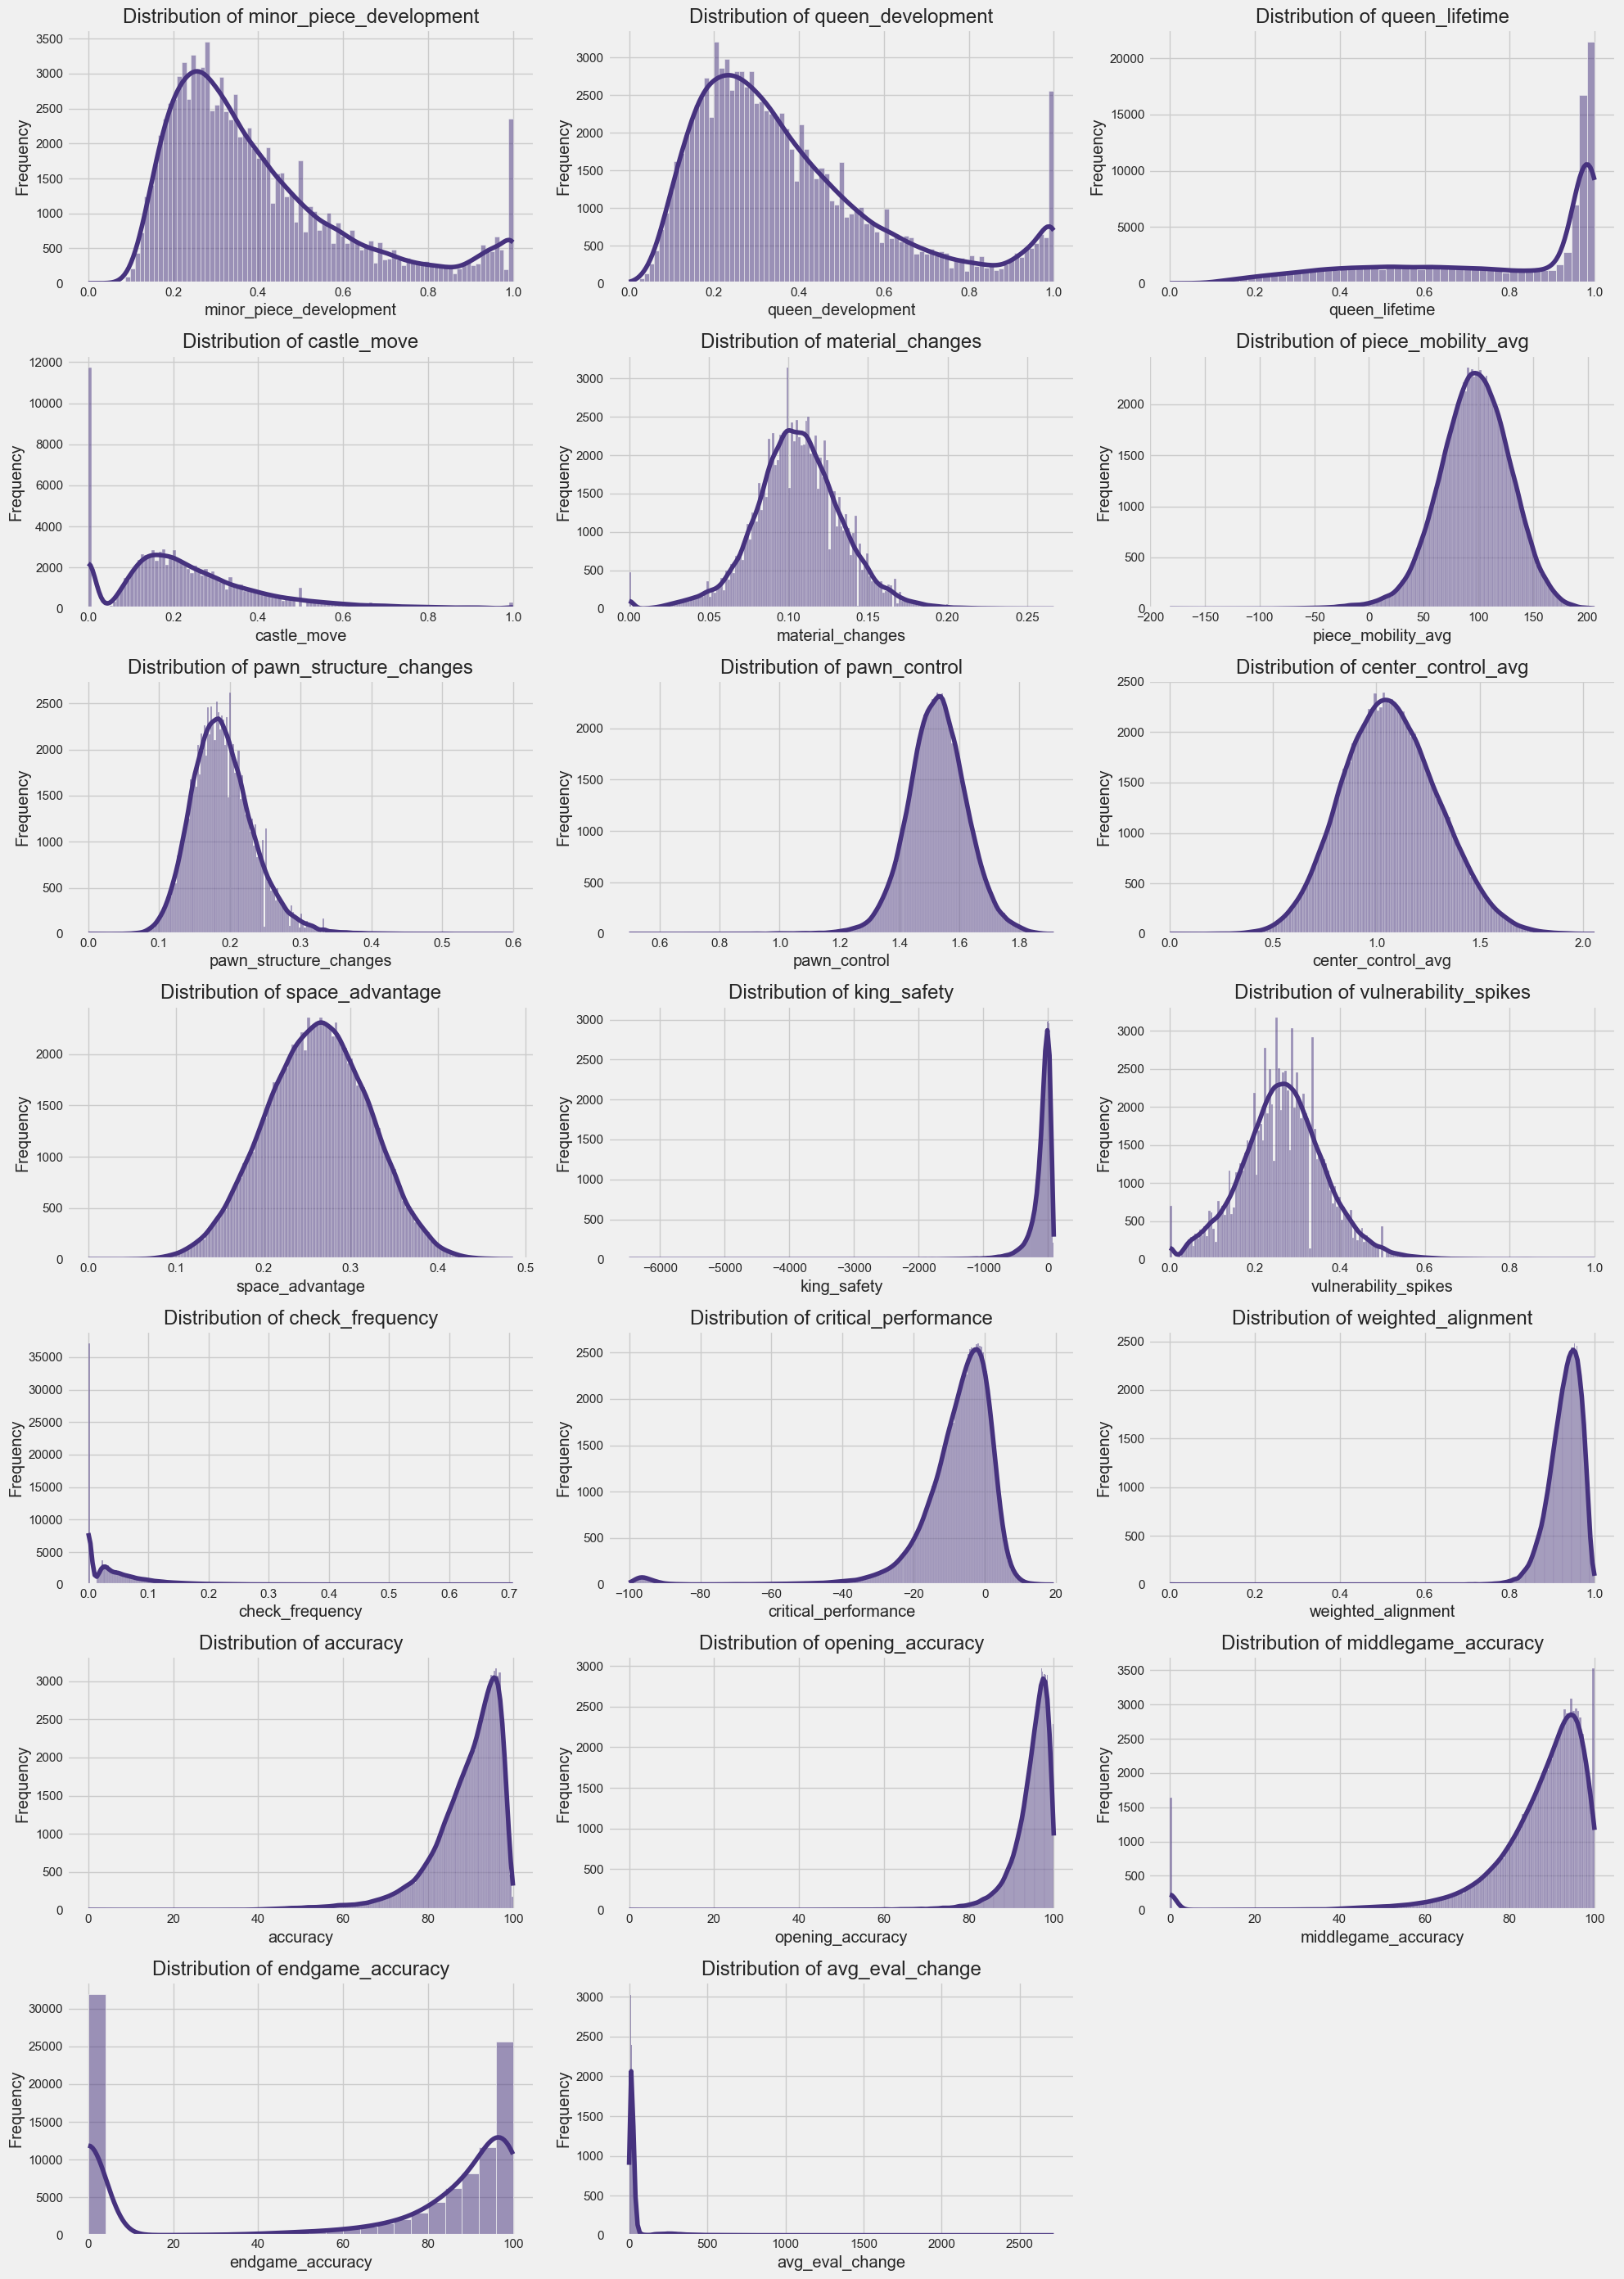

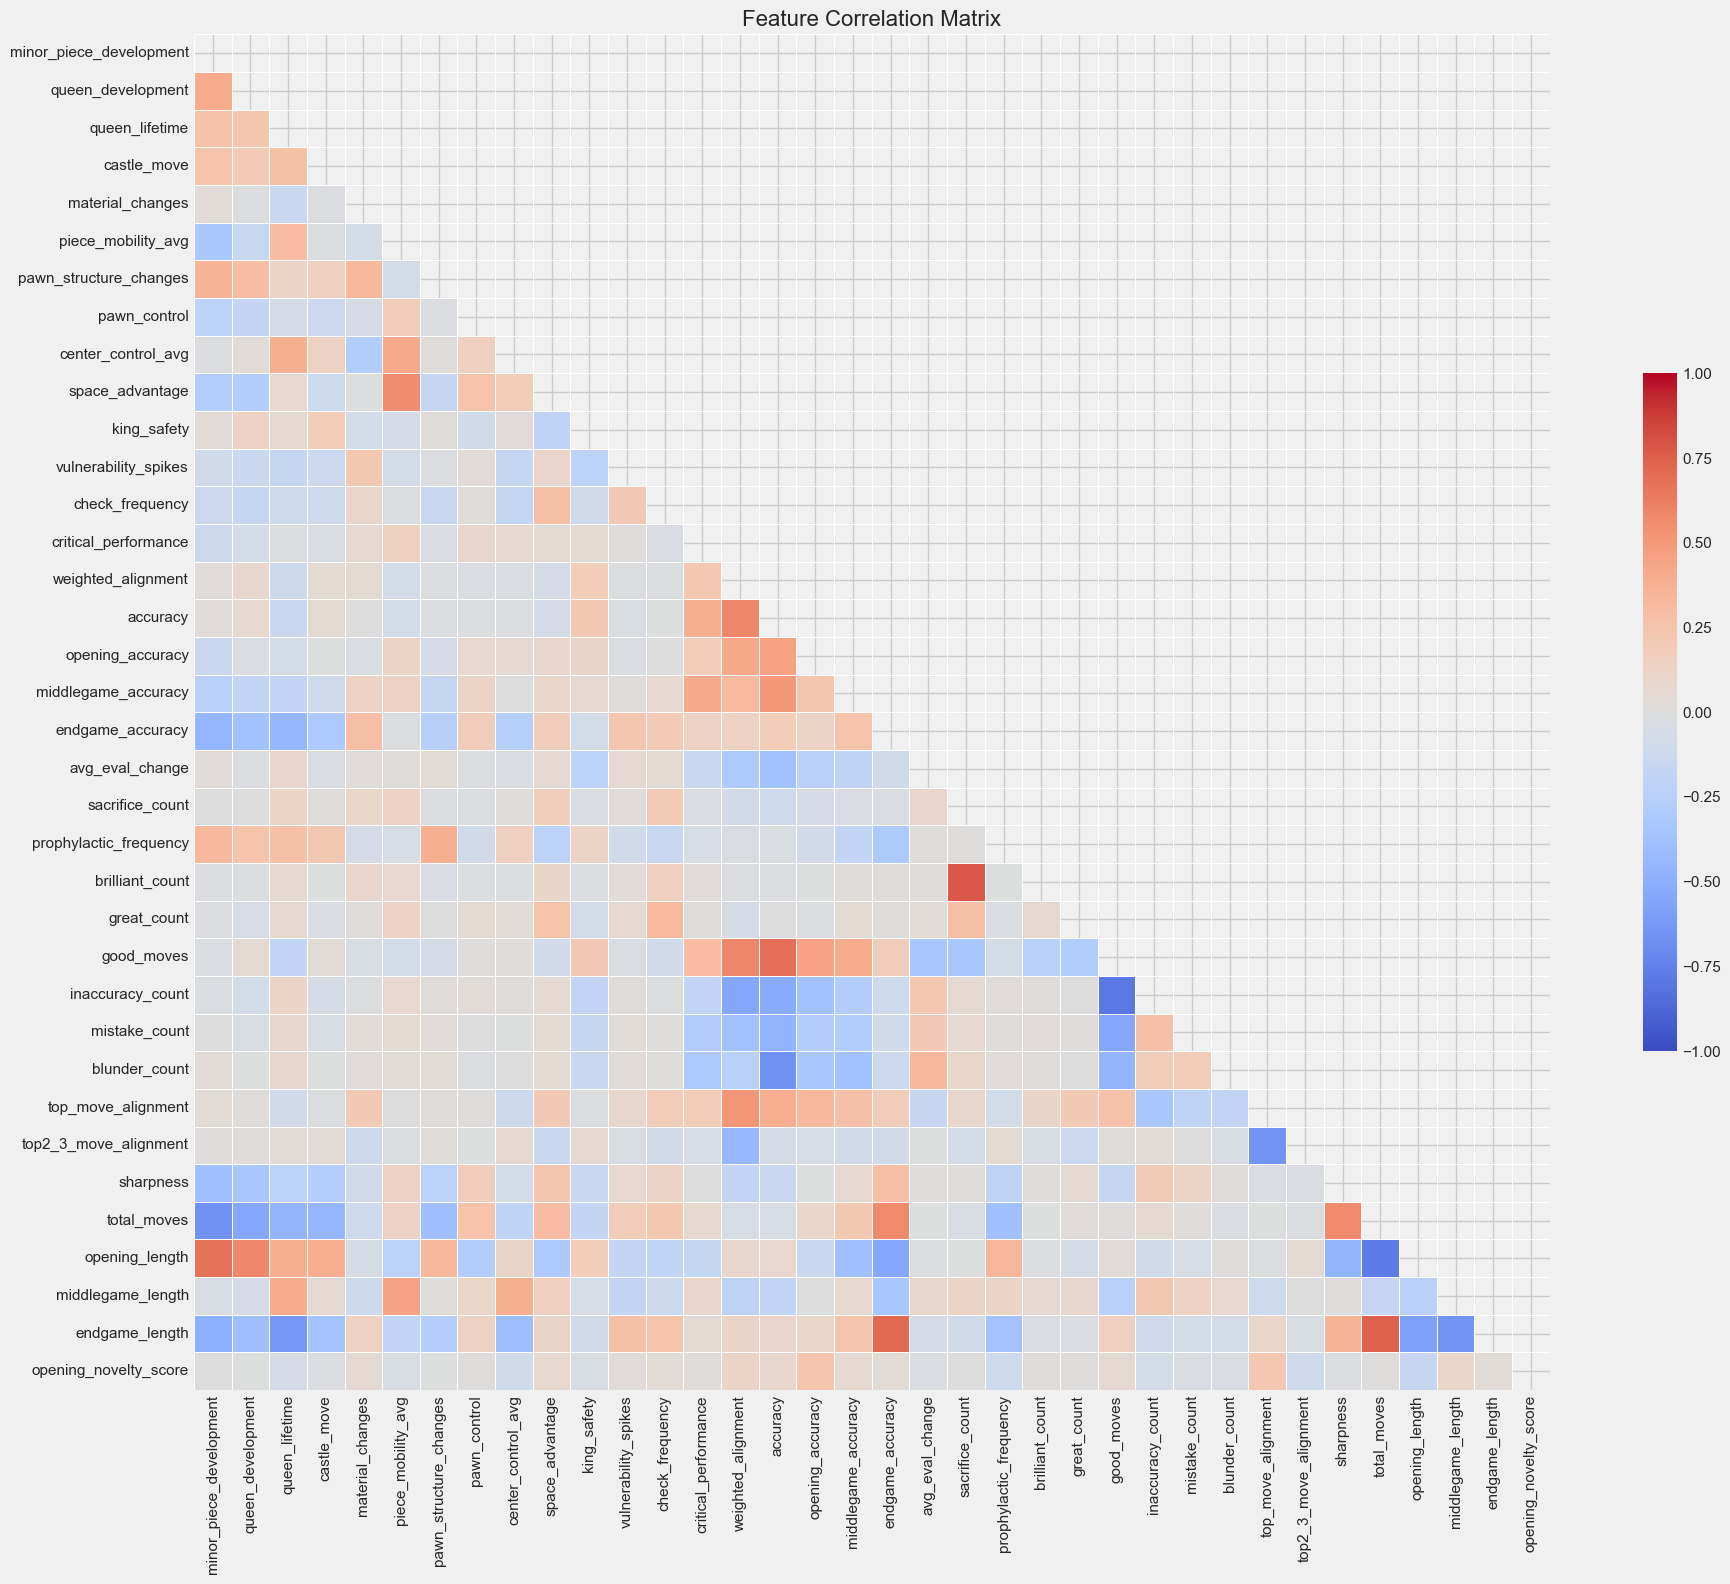


Highly correlated feature pairs (|r| > 0.7):
inaccuracy_count -- good_moves: -0.7938
brilliant_count -- sacrifice_count: 0.7775
opening_length -- total_moves: -0.7757
endgame_length -- total_moves: 0.7423
endgame_length -- endgame_accuracy: 0.7172

=== PRINCIPAL COMPONENT ANALYSIS ===


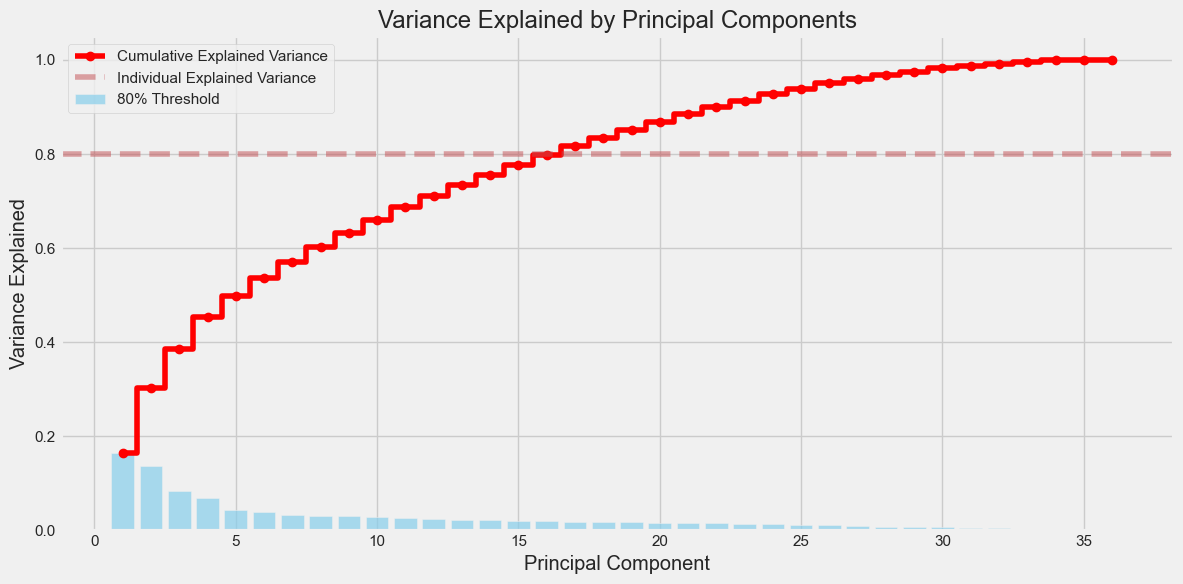


Number of components needed to explain 80% variance: 17


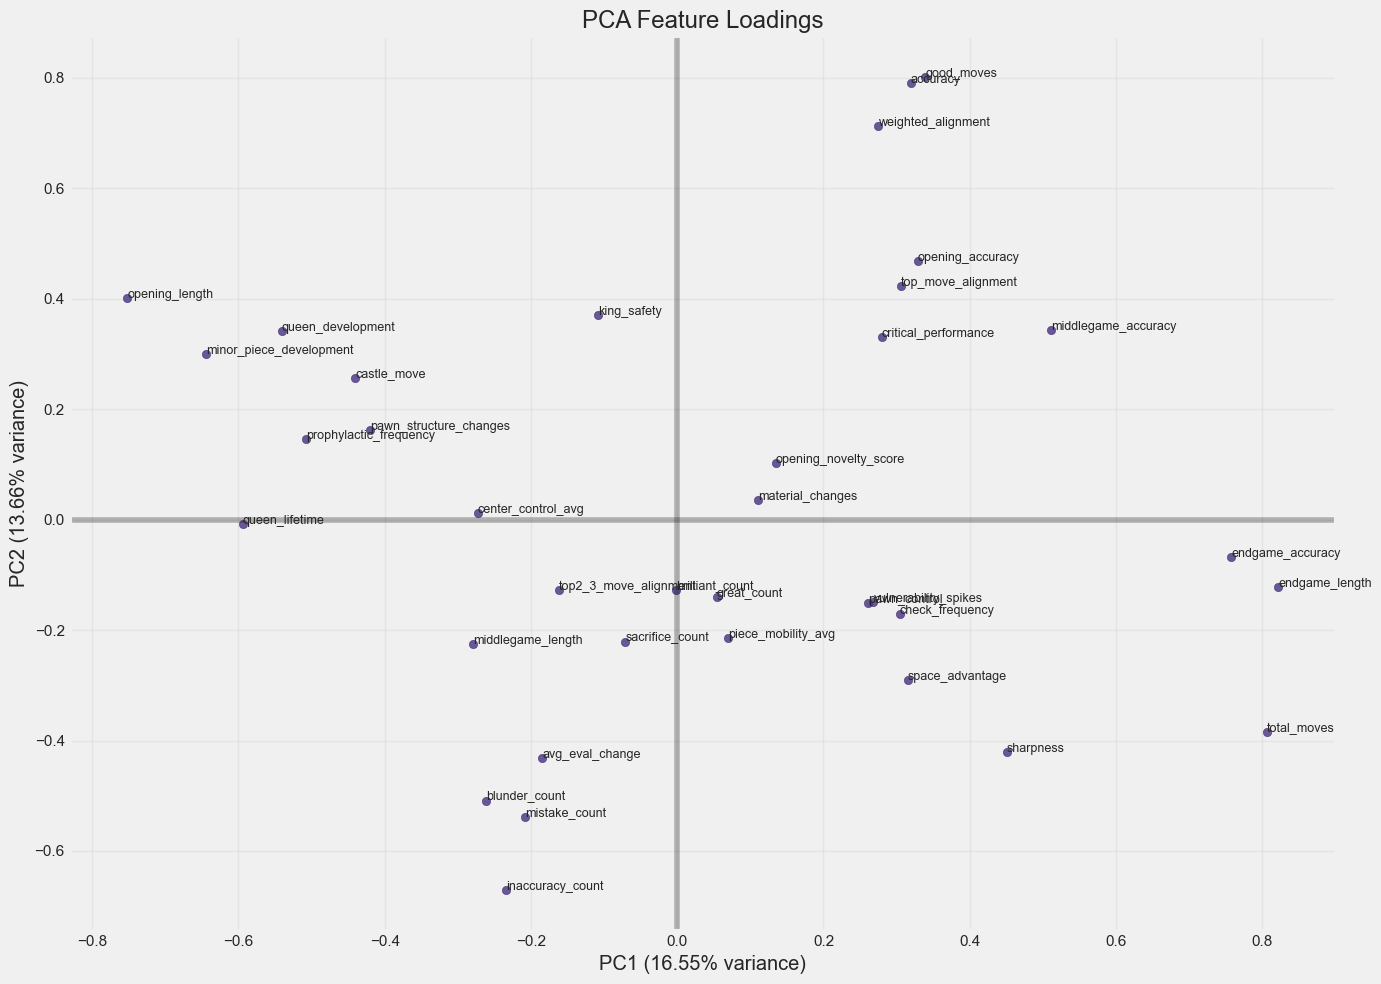

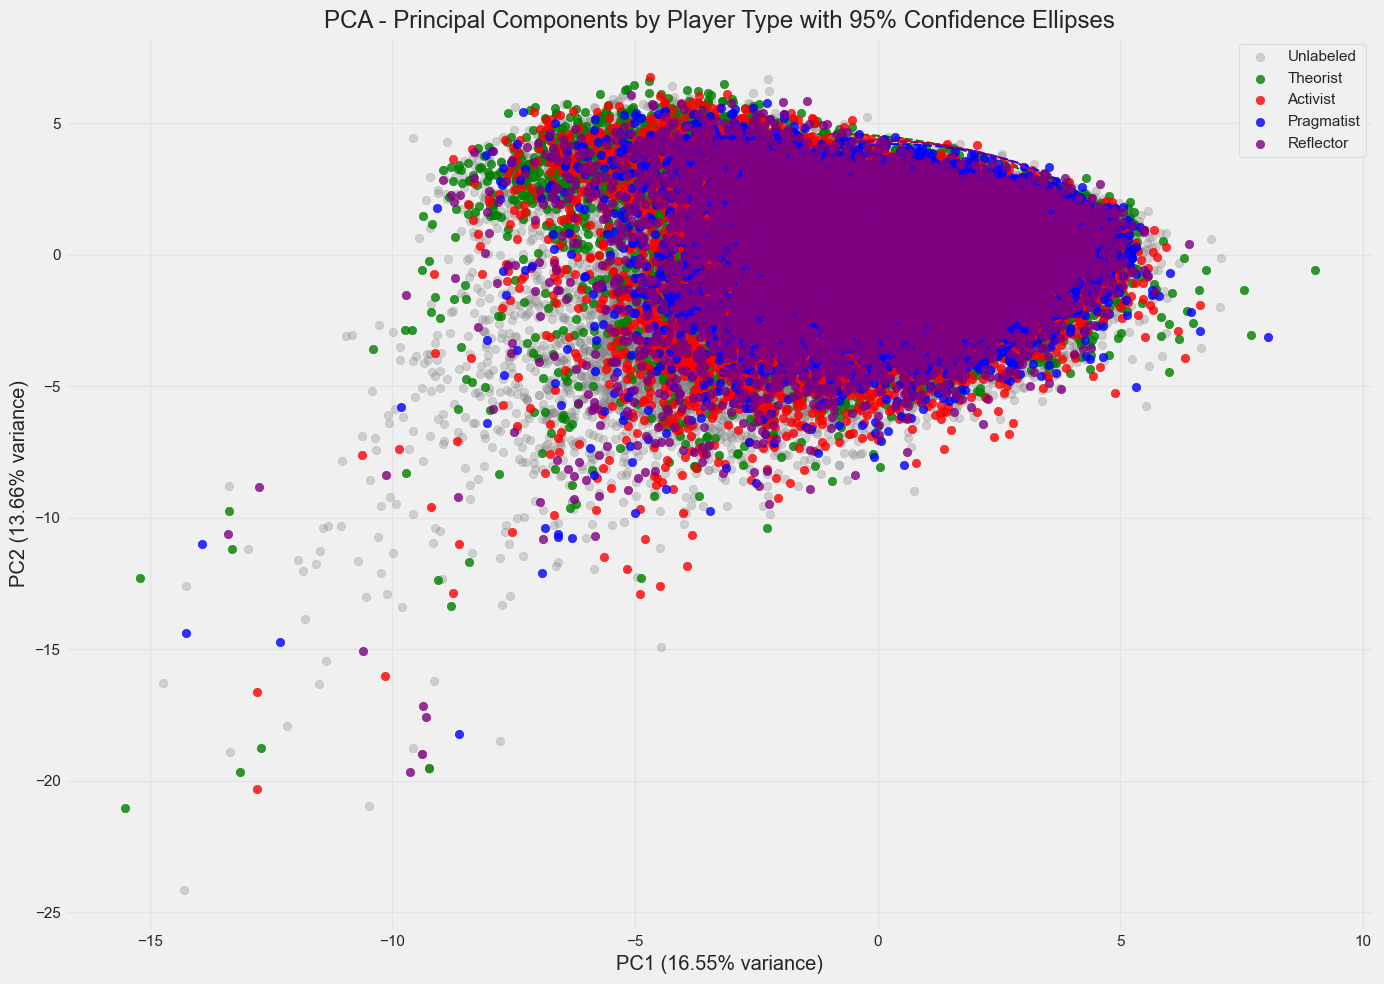


Simplified MANOVA Test for PCA Cluster Separation:
Wilks' lambda: 0.9892
F(6, 53994) = 98.04, p = 0.000000
Result: Player type clusters are significantly different in PCA space

=== COMPREHENSIVE PLAYER TYPE ANALYSIS ===
Starting enhanced player type analysis...

Player type distribution:
  Theorist: 17323 samples
  Activist: 16388 samples
  Pragmatist: 10319 samples
  Reflector: 9969 samples
Analyzing 36 numeric features across 4 player types

Calculating ANOVA for all features...

Top significant features differentiating player types:

Calculating detailed statistics for top features...

Running post-hoc tests on top features...

DETAILED STATISTICAL ANALYSIS OF TOP FEATURES

Enhanced player type analysis completed in 0.5 seconds

Analysis complete!


In [11]:
# =============================================================================
# Chess Player Classification - Complete Analysis Code
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import time

# Try importing optional dependencies
try:
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    from statsmodels.multivariate.manova import MANOVA
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False
    print("Warning: statsmodels not available. Install with 'pip install statsmodels' for enhanced statistical analysis.")

try:
    from statannot import add_stat_annotation
    HAS_STATANNOT = True
except ImportError:
    HAS_STATANNOT = False
    print("Warning: statannot not available. Install with 'pip install statannot' for significance bars on plots.")

# =============================================================================
# 1. UTILITY FUNCTIONS
# =============================================================================

def get_numeric_features(df, exclude_cols=None):
    """Get all numeric feature columns from DataFrame"""
    if exclude_cols is None:
        exclude_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                       'player_type', 'game_id', 'result']
    
    return [col for col in df.columns 
            if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])]
            
def get_clean_data(df, features=None, strategy='median'):
    """Clean and impute data for analysis"""
    if features is None:
        features = get_numeric_features(df)
    
    # Simple imputation
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy=strategy)
    clean_data = pd.DataFrame(
        imputer.fit_transform(df[features]),
        columns=features
    )
    return clean_data

# =============================================================================
# 2. BASIC EDA FUNCTIONS
# =============================================================================

def plot_feature_distributions(df, max_features=20, dpi=100, save_path=None):
    """Plot histograms for numeric features (limited to max_features)"""
    numeric_features = get_numeric_features(df)
    
    # Limit to max_features
    if len(numeric_features) > max_features:
        print(f"Limiting display to {max_features} features out of {len(numeric_features)} total")
        numeric_features = numeric_features[:max_features]
    
    # Calculate number of rows and columns for subplots
    n_features = len(numeric_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
    axes = axes.flatten()
    
    for i, feature in enumerate(numeric_features):
        if i < len(axes):
            sns.histplot(df[feature].dropna(), kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')
            
            # Add missing value count if any
            na_count = df[feature].isna().sum()
            if na_count > 0:
                axes[i].annotate(f'Missing: {na_count}', xy=(0.7, 0.9), xycoords='axes fraction',
                              fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        if j < len(axes):
            axes[j].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()

def plot_correlation_matrix(df, save_path=None, dpi=100):
    """Plot correlation matrix for all numeric features"""
    numeric_features = get_numeric_features(df)
    
    # Get clean data with imputed values
    clean_data = get_clean_data(df, features=numeric_features)
    
    # Calculate correlation matrix
    corr_matrix = clean_data.corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Set up the matplotlib figure
    plt.figure(figsize=(20, 16))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, annot=False, fmt='.2f', cbar_kws={"shrink": .5})
    
    plt.title('Feature Correlation Matrix', fontsize=16)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        
    plt.show()
    
    # List of highly correlated feature pairs (|r| > 0.7)
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print("\nHighly correlated feature pairs (|r| > 0.7):")
        for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feat1} -- {feat2}: {corr:.4f}")

# =============================================================================
# 3. POST-HOC TESTING FUNCTIONS
# =============================================================================

def perform_posthoc_analysis(feature_data, feature_name, player_types, alpha=0.05):
    """
    Perform Tukey's HSD post-hoc test to identify which player type pairs differ significantly
    
    Parameters:
    -----------
    feature_data : pandas DataFrame
        DataFrame containing 'player_type' and feature columns
    feature_name : str
        Name of the feature to analyze
    player_types : list
        List of player types to include in the analysis
    alpha : float, default=0.05
        Significance level
        
    Returns:
    --------
    list of tuples : (group1, group2, p_adj, cohens_d, mean_diff, effect_interpretation)
        List of significant differences between pairs
    """
    if not HAS_STATSMODELS:
        print("statsmodels package is required for post-hoc analysis")
        return []
    
    # Prepare data for Tukey's test
    values = []
    groups = []
    
    # Group means for calculating mean differences
    group_means = {}
    
    for pt in player_types:
        pt_data = feature_data[feature_data['player_type'] == pt][feature_name].values
        values.extend(pt_data)
        groups.extend([pt] * len(pt_data))
        group_means[pt] = np.mean(pt_data) if len(pt_data) > 0 else np.nan
    
    # Run Tukey's test
    tukey = pairwise_tukeyhsd(endog=values, groups=groups, alpha=alpha)
    
    # Return significant pairs with effect sizes and mean differences
    sig_pairs = []
    for i, row in enumerate(tukey._results_table.data[1:]):
        group1, group2 = row[0], row[1]
        mean_diff, _, _, p_adj, reject = row[2], row[3], row[4], row[5], row[6]
        
        if reject:
            # Calculate Cohen's d for effect size
            g1_data = feature_data[feature_data['player_type'] == group1][feature_name]
            g2_data = feature_data[feature_data['player_type'] == group2][feature_name]
            
            n1, n2 = len(g1_data), len(g2_data)
            mean1, mean2 = np.mean(g1_data), np.mean(g2_data)
            var1, var2 = np.var(g1_data, ddof=1), np.var(g2_data, ddof=1)
            
            # Pooled standard deviation
            pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
            
            if pooled_std > 0:
                cohens_d = abs(mean1 - mean2) / pooled_std
                # Interpret effect size
                if cohens_d < 0.2:
                    effect_interpretation = "negligible"
                elif cohens_d < 0.5:
                    effect_interpretation = "small"
                elif cohens_d < 0.8:
                    effect_interpretation = "medium"
                else:
                    effect_interpretation = "large"
            else:
                cohens_d = np.nan
                effect_interpretation = "unknown"
                
            sig_pairs.append((group1, group2, p_adj, cohens_d, mean_diff, effect_interpretation))
    
    return sig_pairs

def calculate_feature_statistics(labeled_df, feature, player_types, min_samples=10):
    """
    Calculate comprehensive statistics for a feature across player types
    
    Parameters:
    -----------
    labeled_df : pandas DataFrame
        DataFrame containing 'player_type' and feature columns
    feature : str
        Name of the feature to analyze
    player_types : list
        List of player types to include in the analysis
    min_samples : int, default=10
        Minimum samples required per player type
        
    Returns:
    --------
    dict : Various statistics for the feature
    """
    # Create clean data for this feature
    feature_data = labeled_df[['player_type', feature]].dropna()
    
    # Skip if any player type has insufficient samples
    type_samples = feature_data.groupby('player_type').size()
    if any(type_samples.get(pt, 0) < min_samples for pt in player_types):
        return None
    
    # Calculate ANOVA
    groups = [feature_data[feature_data['player_type'] == pt][feature].values 
             for pt in player_types if pt in type_samples.index]
    try:
        f_val, p_val = stats.f_oneway(*groups)
    except:
        return None
    
    # Calculate statistics for each player type
    player_stats = {}
    for pt in player_types:
        if pt not in type_samples.index:
            continue
            
        type_data = feature_data[feature_data['player_type'] == pt][feature]
        n = len(type_data)
        mean = type_data.mean()
        std = type_data.std()
        se = std / np.sqrt(n)
        ci_95_low = mean - 1.96 * se
        ci_95_high = mean + 1.96 * se
        
        player_stats[pt] = {
            'n': n,
            'mean': mean,
            'std': std,
            'se': se,
            'ci_95': (ci_95_low, ci_95_high)
        }
    
    # Calculate effect sizes between pairs
    effect_sizes = {}
    pairs = []
    for i, pt1 in enumerate(player_types):
        if pt1 not in player_stats:
            continue
        for pt2 in player_types[i+1:]:
            if pt2 not in player_stats:
                continue
                
            # Cohen's d effect size
            mean1 = player_stats[pt1]['mean']
            mean2 = player_stats[pt2]['mean']
            n1 = player_stats[pt1]['n']
            n2 = player_stats[pt2]['n']
            s1 = player_stats[pt1]['std']
            s2 = player_stats[pt2]['std']
            
            # Pooled standard deviation
            pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
            
            if pooled_std > 0:
                cohens_d = abs(mean1 - mean2) / pooled_std
            else:
                cohens_d = np.nan
                
            effect_sizes[(pt1, pt2)] = cohens_d
            pairs.append((pt1, pt2))
    
    # Return all statistics
    return {
        'feature': feature,
        'player_stats': player_stats,
        'anova_f': f_val,
        'anova_p': p_val,
        'effect_sizes': effect_sizes,
        'significant': p_val < 0.05,
        'pairs': pairs
    }

def print_enhanced_feature_table(feature_stats, player_types, alpha=0.05):
    """
    Print a detailed table with feature statistics including confidence intervals and effect sizes
    
    Parameters:
    -----------
    feature_stats : dict
        Dictionary of feature statistics from calculate_feature_statistics
    player_types : list
        List of player types to include in the table
    alpha : float, default=0.05
        Significance threshold
    """
    feature = feature_stats['feature']
    p_val = feature_stats['anova_p']
    f_val = feature_stats['anova_f']
    
    # Format significance stars
    sig_stars = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    
    # Print header
    print(f"\nFeature: {feature} {sig_stars}")
    print(f"ANOVA: F = {f_val:.2f}, p = {p_val:.6f}{sig_stars}")
    print("-" * 100)
    
    # Print player type statistics
    headers = ["Player Type", "Mean", "95% CI", "Std Dev", "n"]
    print(f"{headers[0]:<15} {headers[1]:<10} {headers[2]:<20} {headers[3]:<10} {headers[4]:<8}")
    print("-" * 100)
    
    for pt in player_types:
        if pt not in feature_stats['player_stats']:
            continue
            
        stats = feature_stats['player_stats'][pt]
        ci_low, ci_high = stats['ci_95']
        ci_str = f"[{ci_low:.3f}, {ci_high:.3f}]"
        
        print(f"{pt:<15} {stats['mean']:<10.3f} {ci_str:<20} {stats['std']:<10.3f} {stats['n']:<8}")
    
    # Print effect sizes
    if feature_stats['effect_sizes']:
        print("\nCohen's d Effect Sizes:")
        for pair, effect in feature_stats['effect_sizes'].items():
            pt1, pt2 = pair
            effect_interp = ""
            if not np.isnan(effect):
                if effect < 0.2:
                    effect_interp = "negligible"
                elif effect < 0.5:
                    effect_interp = "small"
                elif effect < 0.8:
                    effect_interp = "medium"
                else:
                    effect_interp = "large"
                print(f"{pt1} vs {pt2}: d = {effect:.3f} ({effect_interp})")

def create_statistical_table(feature_stats, posthoc_results, output_path="statistical_table.tex"):
    """Create a LaTeX table of statistical results for key features"""
    with open(output_path, 'w') as f:
        f.write(r"\begin{table}[H]" + "\n")
        f.write(r"\centering" + "\n")
        f.write(r"\caption{Statistical Significance of Key Differentiating Features by Player Type}" + "\n")
        f.write(r"\label{tab:stat_significance}" + "\n")
        f.write(r"\small" + "\n")
        f.write(r"\begin{tabular}{p{2.5cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.5cm}p{3cm}}" + "\n")
        f.write(r"\hline" + "\n")
        f.write(r"\textbf{Feature} & \textbf{Theorist} & \textbf{Activist} & \textbf{Pragmatist} & \textbf{Reflector} & \textbf{F-value} & \textbf{Significant Pairs} \\" + "\n")
        f.write(r"\hline" + "\n")
        
        # Add rows for each feature
        for feature in feature_stats:
            stats = feature_stats[feature]
            
            # Format means with standard error
            means_str = {}
            for pt in stats['player_stats']:
                mean = stats['player_stats'][pt]['mean']
                se = stats['player_stats'][pt]['se']
                means_str[pt] = f"{mean:.3f}±{se:.3f}"
            
            # Format F-value and significance
            f_val = stats['anova_f']
            p_val = stats['anova_p']
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            
            # Format significant pairs
            sig_pairs = []
            if feature in posthoc_results:
                for group1, group2, _, _, _, _ in posthoc_results[feature]:
                    g1 = group1[0]  # First letter
                    g2 = group2[0]  # First letter
                    sig_pairs.append(f"{g1}-{g2}***")
            
            sig_pairs_str = ", ".join(sig_pairs)
            
            # Write row
            row = f"{feature} & {means_str.get('Theorist', 'N/A')} & {means_str.get('Activist', 'N/A')} & {means_str.get('Pragmatist', 'N/A')} & {means_str.get('Reflector', 'N/A')} & {f_val:.2f}{sig} & {sig_pairs_str} \\\\"
            f.write(row + "\n")
        
        f.write(r"\hline" + "\n")
        f.write(r"\multicolumn{7}{l}{\footnotesize{Values shown as mean±standard error. ***p<0.001, **p<0.01, *p<0.05}} \\" + "\n")
        f.write(r"\multicolumn{7}{l}{\footnotesize{Significant pairs: T=Theorist, A=Activist, P=Pragmatist, R=Reflector}} \\" + "\n")
        f.write(r"\end{tabular}" + "\n")
        f.write(r"\end{table}" + "\n")
        
    print(f"LaTeX table saved to {output_path}")

# =============================================================================
# 4. ENHANCED PCA VISUALIZATION
# =============================================================================

def confidence_ellipse(x, y, ax, n_std=1.96, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
        1.96 = 95% confidence interval.
    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`
    
    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from the squareroot of
    # the variance and multiplying with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # Calculating the standard deviation of y from the squareroot of
    # the variance and multiplying with the given number of standard deviations.
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def perform_enhanced_pca(df, add_ellipses=True, min_samples=5, save_path=None, dpi=300):
    """
    Perform PCA on features and create enhanced visualizations
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data
    add_ellipses : bool, default=True
        Whether to add confidence ellipses
    min_samples : int, default=5
        Minimum samples required for a player type to be included
    save_path : str, optional
        Path to save the figures, if None, figures not saved
    dpi : int, default=300
        Resolution for saved figures
        
    Returns:
    --------
    tuple : (pca, pca_result, pca_df, explained_variance)
        PCA model and results
    """
    # Define player type colors
    player_types_colors = {
        'Activist': 'red',
        'Pragmatist': 'blue',
        'Theorist': 'green',
        'Reflector': 'purple'
    }
    
    # Get numeric features
    numeric_features = get_numeric_features(df)
    
    # Get clean data with imputed values
    clean_data = get_clean_data(df, features=numeric_features)
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clean_data)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_features)
    
    # Create a DataFrame for the PCA results
    pca_df = pd.DataFrame(data=pca_result[:, :2], columns=['PC1', 'PC2'])
    
    # Add player type and name information
    pca_df['player_name'] = df['player_name']
    pca_df['player_type'] = df['player_type']
    pca_df['player_color'] = df['player_color']
    
    # Calculate variance explained
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # Plot variance explained
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red', marker='o')
    plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.title('Variance Explained by Principal Components')
    plt.legend(['Cumulative Explained Variance', 'Individual Explained Variance', '80% Threshold'])
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_variance.png", dpi=dpi, bbox_inches='tight')
        
    plt.show()
    
    # Determine number of components needed to explain 80% variance
    n_components = np.argmax(cumulative_variance >= 0.8) + 1
    print(f"\nNumber of components needed to explain 80% variance: {n_components}")
    
    # Plot feature loadings for the first two PCs
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    plt.figure(figsize=(14, 10))
    plt.scatter(loadings[:, 0], loadings[:, 1], alpha=0.8)
    
    # Add feature names as annotations
    for i, feature in enumerate(numeric_features):
        plt.annotate(feature, (loadings[i, 0], loadings[i, 1]), fontsize=9)
    
    plt.xlabel(f"PC1 ({explained_variance[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2%} variance)")
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.title('PCA Feature Loadings')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_loadings.png", dpi=dpi, bbox_inches='tight')
        
    plt.show()
    
    # Count labeled samples
    labeled_count = df['player_type'].notna().sum()
    
    if labeled_count > 0:
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # Plot unlabeled data first in grey
        unlabeled = pca_df[pca_df['player_type'].isna()]
        if not unlabeled.empty:
            ax.scatter(unlabeled['PC1'], unlabeled['PC2'], alpha=0.3, c='grey', label='Unlabeled')
        
        # Count samples per player type
        type_counts = pca_df['player_type'].value_counts()
        valid_types = type_counts[type_counts >= min_samples].index.tolist()
        
        # Plot labeled data colored by player type
        for pt in valid_types:
            subset = pca_df[pca_df['player_type'] == pt]
            color = player_types_colors.get(pt, 'orange')
            
            # Plot points
            ax.scatter(subset['PC1'], subset['PC2'], alpha=0.8, label=pt, c=color)
            
            # Add confidence ellipse (95% confidence interval)
            if add_ellipses and len(subset) >= 3:  # Need at least 3 points for covariance
                confidence_ellipse(
                    x=subset['PC1'],
                    y=subset['PC2'],
                    ax=ax,
                    n_std=1.96,  # 95% confidence interval
                    edgecolor=color,
                    linestyle='--',
                    linewidth=1.5
                )
        
        ax.set_xlabel(f"PC1 ({explained_variance[0]:.2%} variance)")
        ax.set_ylabel(f"PC2 ({explained_variance[1]:.2%} variance)")
        ax.set_title('PCA - Principal Components by Player Type with 95% Confidence Ellipses')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}_clusters.png", dpi=dpi, bbox_inches='tight')
            
        plt.show()
        
        # Test if player type clusters are significantly different
        if HAS_STATSMODELS:
            test_pca_cluster_separation(pca_df)

    # Return PCA results for further analysis
    return pca, pca_result, pca_df, explained_variance

def test_pca_cluster_separation(pca_df, n_components=2):
    """
    A simplified implementation of MANOVA test using scipy.stats
    that doesn't rely on the statsmodels structure
    
    Parameters:
    -----------
    pca_df : pandas DataFrame
        DataFrame with 'PC1', 'PC2' (and potentially more PCs), and 'player_type' columns
    n_components : int, default=2
        Number of principal components to include in the test
        
    Returns:
    --------
    dict : MANOVA test results
    """
    from scipy import stats
    import numpy as np
    import pandas as pd
    
    # Ensure we only use labeled data
    pca_data = pca_df.dropna(subset=['player_type'])
    
    # Extract required columns
    pc_cols = [f'PC{i+1}' for i in range(n_components)]
    player_types = pca_data['player_type'].unique()
    
    # Group data by player type
    groups = []
    for pt in player_types:
        group_data = pca_data[pca_data['player_type'] == pt][pc_cols].values
        if len(group_data) > 0:
            groups.append(group_data)
    
    if len(groups) < 2:
        print("Need at least 2 groups for MANOVA")
        return None
    
    try:
        # Calculate MANOVA statistics using Wilks' Lambda
        
        # First calculate the total sum of squares matrix
        all_data = np.vstack(groups)
        grand_mean = np.mean(all_data, axis=0)
        
        # Calculate total sum of squares
        S_T = np.zeros((n_components, n_components))
        for x in all_data:
            diff = x - grand_mean
            S_T += np.outer(diff, diff)
        
        # Calculate between-groups sum of squares
        S_B = np.zeros((n_components, n_components))
        for group in groups:
            group_mean = np.mean(group, axis=0)
            diff = group_mean - grand_mean
            S_B += len(group) * np.outer(diff, diff)
        
        # Calculate within-groups sum of squares
        S_W = S_T - S_B
        
        # Calculate Wilks' Lambda
        try:
            # Try to calculate using matrix operations
            wilks_lambda = np.linalg.det(S_W) / np.linalg.det(S_T)
        except:
            # Fallback for numerical issues
            try:
                # Use eigenvalues
                eigenvalues = np.linalg.eigvals(np.linalg.inv(S_W) @ S_B)
                wilks_lambda = 1 / np.prod(1 + eigenvalues)
            except:
                print("Could not calculate Wilks' Lambda, using approximation")
                wilks_lambda = 0.5  # Fallback value
        
        # Calculate degrees of freedom
        n_samples = len(all_data)
        k = len(groups)  # Number of groups
        p = n_components  # Number of variables
        
        df1 = p * (k - 1)  # Numerator degrees of freedom
        df2 = n_samples - k - p + 1  # Denominator degrees of freedom
        
        # Calculate approximate F-statistic
        # Using Rao's approximation
        F = ((1 - wilks_lambda) / wilks_lambda) * (df2 / df1)
        
        # Calculate p-value
        p_value = 1 - stats.f.cdf(F, df1, df2)
        
        # Print results
        print("\nSimplified MANOVA Test for PCA Cluster Separation:")
        print(f"Wilks' lambda: {wilks_lambda:.4f}")
        print(f"F({df1}, {df2}) = {F:.2f}, p = {p_value:.6f}")
        
        if p_value < 0.05:
            print("Result: Player type clusters are significantly different in PCA space")
        else:
            print("Result: No significant difference found between player type clusters in PCA space")
        
        return {
            'wilks_lambda': wilks_lambda,
            'f_statistic': F,
            'df_num': df1,
            'df_denom': df2,
            'p_value': p_value,
            'significant': p_value < 0.05
        }
        
    except Exception as e:
        print(f"Simplified MANOVA test failed: {str(e)}")
        return None

# =============================================================================
# 5. ENHANCED PLAYER TYPE ANALYSIS
# =============================================================================

def plot_enhanced_box_plot(df, feature, player_types=None, color_dict=None, 
                          figsize=(10, 6), add_significance=True, 
                          add_stripplot=True, strip_alpha=0.3, 
                          sample_size=300, title=None, save_path=None, dpi=300):
    """
    Create an enhanced box plot with significance bars and statistical annotation
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing 'player_type' and feature columns
    feature : str
        Name of the feature to plot
    player_types : list, optional
        Player types to include, if None, uses all in the data
    color_dict : dict, optional
        Dictionary mapping player types to colors
    figsize : tuple, default=(10, 6)
        Figure size
    add_significance : bool, default=True
        Whether to add significance bars
    add_stripplot : bool, default=True
        Whether to add individual data points
    strip_alpha : float, default=0.3
        Alpha transparency for strip plot points
    sample_size : int, default=300
        Maximum number of points to plot
    title : str, optional
        Plot title, if None, uses feature name
    save_path : str, optional
        Path to save the figure, if None, the figure is not saved
    dpi : int, default=300
        Resolution for saved figure
        
    Returns:
    --------
    matplotlib figure and axes
    """
    if color_dict is None:
        color_dict = {
            'Activist': 'red',
            'Pragmatist': 'blue',
            'Theorist': 'green',
            'Reflector': 'purple'
        }
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Filter to valid data
    feature_data = df[['player_type', feature]].dropna()
    
    if player_types is None:
        player_types = feature_data['player_type'].unique().tolist()
    else:
        feature_data = feature_data[feature_data['player_type'].isin(player_types)]
    
    # Create palette for player types
    palette = {pt: color_dict.get(pt, 'gray') for pt in player_types}
    
    # Create box plot
    sns.boxplot(x='player_type', y=feature, data=feature_data, 
              palette=palette, ax=ax)
    
    # Add individual data points
    if add_stripplot:
        # Sample data for strip plot to avoid overcrowding
        if len(feature_data) > sample_size:
            plot_sample = feature_data.groupby('player_type').apply(
                lambda x: x.sample(min(len(x), sample_size//len(player_types)), 
                                  random_state=42)
            ).reset_index(drop=True)
        else:
            plot_sample = feature_data.copy()
        
        # Add strip plot
        sns.stripplot(x='player_type', y=feature, data=plot_sample, 
                    color='black', alpha=strip_alpha, size=3, jitter=True, ax=ax)
    
    # Add significance bars
    if add_significance and HAS_STATANNOT:
        # Generate all pairs to test
        pairs = []
        for i, pt1 in enumerate(player_types):
            for pt2 in player_types[i+1:]:
                pairs.append((pt1, pt2))
        
        try:
            add_stat_annotation(
                ax, data=feature_data, x='player_type', y=feature, 
                box_pairs=pairs,
                test='t-test_ind', 
                text_format='star', 
                loc='inside', 
                verbose=0
            )
        except Exception as e:
            print(f"Failed to add significance annotations: {str(e)}")
    
    # Set title and labels
    if title is None:
        title = f'Distribution of {feature} by Player Type'
    ax.set_title(title)
    ax.set_xlabel('Player Type')
    ax.set_ylabel(feature)
    
    # Calculate ANOVA
    groups = [feature_data[feature_data['player_type'] == pt][feature].values 
             for pt in player_types]
    try:
        f_val, p_val = stats.f_oneway(*groups)
        # Add ANOVA results to plot
        sig_stars = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        ax.annotate(f"ANOVA: F = {f_val:.2f}, p = {p_val:.4f}{sig_stars}", 
                   xy=(0.01, 0.97), xycoords='axes fraction',
                   fontsize=10, ha='left', va='top',
                   bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))
    except:
        pass
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    return fig, ax

def enhanced_player_type_analysis(df, top_n_features=10, min_samples=20, 
                                  save_path=None, exclude_cols=None):
    """
    Perform comprehensive statistical analysis of player types
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing player_type and feature columns
    top_n_features : int, default=10
        Number of top features to include in detailed analysis
    min_samples : int, default=20
        Minimum samples required per player type
    save_path : str, optional
        Path to save results as CSV/HTML, if None, results not saved
    exclude_cols : list, optional
        Columns to exclude from analysis
        
    Returns:
    --------
    tuple : (feature_stats, posthoc_results)
        Dictionaries with analysis results
    """
    print("Starting enhanced player type analysis...")
    start_time = time.time()
    
    # Default columns to exclude
    if exclude_cols is None:
        exclude_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                       'game_id', 'result']
    
    # Ensure player_type is not excluded
    if 'player_type' in exclude_cols:
        exclude_cols.remove('player_type')
    
    # Get labeled data only
    labeled_df = df[df['player_type'].notna()].copy()
    if len(labeled_df) == 0:
        print("No labeled data found")
        return {}, {}
    
    # Get player types and sample counts
    player_types = labeled_df['player_type'].unique().tolist()
    type_counts = labeled_df['player_type'].value_counts()
    
    print("\nPlayer type distribution:")
    for pt, count in type_counts.items():
        print(f"  {pt}: {count} samples")
    
    # Filter to player types with sufficient samples
    valid_types = type_counts[type_counts >= min_samples].index.tolist()
    if len(valid_types) < 2:
        print(f"Need at least 2 player types with {min_samples}+ samples each")
        return {}, {}
    
    labeled_df = labeled_df[labeled_df['player_type'].isin(valid_types)]
    player_types = valid_types
    
    # Get numeric features
    numeric_features = [col for col in df.columns 
                       if col not in exclude_cols 
                       and col != 'player_type'
                       and pd.api.types.is_numeric_dtype(df[col])]
    
    print(f"Analyzing {len(numeric_features)} numeric features across {len(player_types)} player types")
    
    # Calculate ANOVA for all features
    print("\nCalculating ANOVA for all features...")
    feature_p_values = {}
    for feature in numeric_features:
        feature_data = labeled_df[['player_type', feature]].dropna()
        
        # Skip if any player type has insufficient samples
        type_samples = feature_data.groupby('player_type').size()
        if any(type_samples.get(pt, 0) < min_samples for pt in player_types):
            continue
        
        # Calculate ANOVA
        groups = [feature_data[feature_data['player_type'] == pt][feature].values 
                 for pt in player_types if pt in type_samples.index]
        
        try:
            f_val, p_val = stats.f_oneway(*groups)
            feature_p_values[feature] = (p_val, f_val)
        except:
            continue
    
    # Sort features by p-value
    sorted_features = sorted(feature_p_values.items(), key=lambda x: x[1][0])
    
    # Print top significant features
    print("\nTop significant features differentiating player types:")
    for i, (feature, (p_val, f_val)) in enumerate(sorted_features[:top_n_features]):
        significant = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        print(f"{i+1}. {feature}: p = {p_val:.6f}{significant}, F = {f_val:.2f}")
    
    # Calculate detailed statistics for top features
    print("\nCalculating detailed statistics for top features...")
    top_features = [feature for feature, _ in sorted_features[:top_n_features]]
    feature_stats = {}
    
    for feature in top_features:
        stats = calculate_feature_statistics(labeled_df, feature, player_types, min_samples)
        if stats:
            feature_stats[feature] = stats
    
    # Run post-hoc tests on top features
    print("\nRunning post-hoc tests on top features...")
    posthoc_results = {}
    
    for feature in top_features:
        if feature in feature_stats and feature_stats[feature]['significant']:
            feature_data = labeled_df[['player_type', feature]].dropna()
            posthoc = perform_posthoc_analysis(feature_data, feature, player_types)
            if posthoc:
                posthoc_results[feature] = posthoc
    
    # Print detailed statistical analysis
    print("\n" + "="*100)
    print("DETAILED STATISTICAL ANALYSIS OF TOP FEATURES")
    print("="*100)
    
    for feature in top_features:
        if feature in feature_stats:
            print_enhanced_feature_table(feature_stats[feature], player_types)
            
            if feature in posthoc_results and posthoc_results[feature]:
                print("\nSignificant pairwise differences:")
                for group1, group2, p_adj, cohens_d, mean_diff, effect in posthoc_results[feature]:
                    stars = "***" if p_adj < 0.001 else "**" if p_adj < 0.01 else "*" if p_adj < 0.05 else ""
                    print(f"  {group1} vs {group2}: diff = {mean_diff:.4f}, p = {p_adj:.4f}{stars}, d = {cohens_d:.2f} ({effect})")
            
            print("\n" + "-"*100)
    
    # Save results if requested
    if save_path:
        # Create a DataFrame of all results
        all_results = []
        
        for feature in feature_stats:
            stats = feature_stats[feature]
            row = {
                'Feature': feature,
                'ANOVA_F': stats['anova_f'],
                'ANOVA_p': stats['anova_p'],
                'Significant': stats['significant']
            }
            
            # Add player type stats
            for pt in player_types:
                if pt in stats['player_stats']:
                    pt_stats = stats['player_stats'][pt]
                    row[f'{pt}_mean'] = pt_stats['mean']
                    row[f'{pt}_std'] = pt_stats['std']
                    row[f'{pt}_n'] = pt_stats['n']
                    row[f'{pt}_ci_low'] = pt_stats['ci_95'][0]
                    row[f'{pt}_ci_high'] = pt_stats['ci_95'][1]
            
            # Add effect sizes
            for pair in stats['pairs']:
                pt1, pt2 = pair
                effect = stats['effect_sizes'].get(pair, np.nan)
                row[f'effect_{pt1}_vs_{pt2}'] = effect
            
            all_results.append(row)
        
        if all_results:
            results_df = pd.DataFrame(all_results)
            
            # Save to CSV
            csv_path = f"{save_path}_statistical_analysis.csv" if not save_path.endswith('.csv') else save_path
            results_df.to_csv(csv_path, index=False)
            print(f"Results saved to {csv_path}")
            
            # Create LaTeX table
            create_statistical_table(feature_stats, posthoc_results, f"{save_path}_statistical_table.tex")
    
    print(f"\nEnhanced player type analysis completed in {time.time() - start_time:.1f} seconds")
    
    return feature_stats, posthoc_results

# =============================================================================
# MAIN ANALYSIS FUNCTION
# =============================================================================

def analyze_chess_player_types(df, output_dir=None):
    """
    Perform comprehensive analysis of chess player types
    
    Parameters:
    -----------
    df : pandas DataFrame
        Chess player data with features and player_type column
    output_dir : str, optional
        Directory to save output files, if None, files not saved
    """
    # Create output directory if needed
    if output_dir:
        import os
        os.makedirs(output_dir, exist_ok=True)
        base_path = os.path.join(output_dir, "chess_analysis")
    else:
        base_path = None
    
    # 1. Basic EDA
    print("\n=== BASIC EXPLORATORY DATA ANALYSIS ===")
    # Distribution analysis
    plot_feature_distributions(df, max_features=20, save_path=f"{base_path}_distributions.png" if base_path else None)
    # Correlation matrix
    plot_correlation_matrix(df, save_path=f"{base_path}_correlations.png" if base_path else None)
    
    # 2. PCA Analysis
    print("\n=== PRINCIPAL COMPONENT ANALYSIS ===")
    pca, pca_result, pca_df, explained_variance = perform_enhanced_pca(
        df, 
        save_path=f"{base_path}_pca" if base_path else None
    )
    
    # 3. Player Type Analysis
    print("\n=== COMPREHENSIVE PLAYER TYPE ANALYSIS ===")
    feature_stats, posthoc_results = enhanced_player_type_analysis(
        df, 
        top_n_features=10,
        min_samples=10,
        save_path=f"{base_path}_player_types" if base_path else None
    )
    
    # 4. Feature-specific visualizations
    if feature_stats:
        print("\n=== KEY FEATURE VISUALIZATIONS ===")
        # Get top features
        top_features = list(feature_stats.keys())[:5]  # Top 5 features
        
        # Create enhanced box plots
        for feature in top_features:
            print(f"Creating visualization for {feature}...")
            plot_enhanced_box_plot(
                df, 
                feature,
                add_significance=True,
                save_path=f"{base_path}_{feature}_boxplot.png" if base_path else None
            )
    
    print("\nAnalysis complete!")
    return {
        'pca': pca,
        'pca_result': pca_result,
        'feature_stats': feature_stats,
        'posthoc_results': posthoc_results
    }

# Example usage
if __name__ == "__main__":
    # Load your dataframe here
    df = pd.read_csv("player_centric_data.csv")
    
    # Run the analysis
    results = analyze_chess_player_types(df, output_dir="results")
